In [1]:
import numpy as np
import matplotlib.pyplot as plt

loss_limits = (-0.1, 1.3)

title_fontsize = 18
label_fontsize = 18 
tick_fontsize = 15
colorbar_fontsize = 17
legend_fontsize = 16

# Defining the VQE Problem Parameters

In [2]:
from dataclasses import dataclass
from qulacs import Observable

@dataclass
class VQEProblem:
    N_QUBITS: int
    DEPTH: int
    TRANSVERSE_FIELD_COEFFICIENT: float
    parameters: list[float]
    LOSS_HAMILTONIAN: Observable
    LOSS_HAMILTONIAN_SPECTRUM: list[float]

# Defining the Loss Hamiltonian

In [3]:
# Defining Ising Hamiltonian
from qulacs import Observable
from scipy.sparse.linalg import eigs

def ising_model_H(n_qubits, transverse_field_coefficient):
    """ising_model_H
    Returns Ising model Hamiltonian observable

    Args:
        n_qubits (:class:`int`):
            the number of qubits
        h_parameter (:class:`float`)
            h parameter of Hamiltonian

    Returns:
        :class:`qulacs.Observable`

    """

    ising_hamiltonian = Observable(n_qubits)

    # Building the Transverse field Ising Hamiltonian
    for i in range(n_qubits-1): ising_hamiltonian.add_operator(1.0 ,f"Z {i} Z {i+1}")
    for i in range(n_qubits): ising_hamiltonian.add_operator(transverse_field_coefficient, f"X {i}")

    if n_qubits < 5:

        n_eigenvalues = 2**(n_qubits-1)

    else:
        n_eigenvalues = 30

    energies = np.real(eigs(ising_hamiltonian.get_matrix(), k=n_eigenvalues, which='SR')[0])

    return ising_hamiltonian, energies

In [4]:
from qulacs import ParametricQuantumCircuit
from qulacs.gate import CZ

def perceptron_circuit(n_qubits, depth, param_list):
    """ansatz_circuit
    Returns ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubits.
        depth (:class:`int`):
            depth of the circuit (the number of layers).
        param_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :class:`qulacs.ParametricQuantumCircuit`
    """

    circuit = ParametricQuantumCircuit(n_qubits)

    gate_offset = 1 * n_qubits # number of parameters per operator times number of operators
    
    for d in range(depth):

        depth_offset = d*gate_offset*4
        # print(depth_offset)

        # print("new layer with depth offset ", depth_offset)

        for i in range(n_qubits):
            theta = param_list[i + gate_offset*0 + depth_offset]
            # print("RX layer ", param_list[i + gate_offset*0 + depth_offset])
            # gate = RX(i, param_list[i + gate_offset*0 + depth_offset])
            circuit.add_parametric_RX_gate(i, theta)

        for i in range(n_qubits):
            theta = param_list[i + gate_offset*1 + depth_offset]
            # print("RZ layer ", param_list[i + gate_offset*1 + depth_offset])
            # gate = RZ(i, param_list[i + gate_offset*1 + depth_offset])
            circuit.add_parametric_RZ_gate(i, theta)


        for i in range(n_qubits-1):
            gate = CZ(i, n_qubits-1)

        for i in range(n_qubits):
            theta = param_list[i + gate_offset*2 + depth_offset]
            # print("RX layer ", param_list[i + gate_offset*2 + depth_offset])
            # gate = RX(i, param_list[i + gate_offset*2 + depth_offset])
            circuit.add_parametric_RX_gate(i, theta)

        for i in range(n_qubits):
            theta = param_list[i+ gate_offset*3 + depth_offset]
            # print("RZ layer ", param_list[i + gate_offset*3 + depth_offset])
            # gate = RZ(i, param_list[i+ gate_offset*3 + depth_offset])
            circuit.add_parametric_RZ_gate(i, theta)


    return circuit


In [5]:
from qulacs import QuantumState

def loss_function(parameters, vqe):
    state = QuantumState(vqe.N_QUBITS)
    circuit = perceptron_circuit(vqe.N_QUBITS, vqe.DEPTH, parameters)
    circuit.update_quantum_state(state)
    return vqe.LOSS_HAMILTONIAN.get_expectation_value(state)

In [6]:
def setup_vqe_problem(problem):
    """Defines a new instance of a VQE problem with random parameters
    
    """
    n_qubits = problem["qubits"]
    depth = problem["depth"]
    trials = problem["trials"]
    transverse_field_coefficient = problem["transverse_field_coefficient"]


    gates_per_layer = n_qubits
    param_dim = gates_per_layer*4*depth
    param_list = np.random.random(param_dim)*1e-1*10

    loss_hamiltonian, loss_hamiltonian_spectrum = ising_model_H(n_qubits, transverse_field_coefficient)

    return VQEProblem(n_qubits, depth, transverse_field_coefficient, param_list, loss_hamiltonian, loss_hamiltonian_spectrum)    

In [7]:
from os import mkdir
from os.path import exists


def create_folder(path):

  if not exists(path):
    mkdir(path)

    print("Folder %s created!" % path)
  else:
    print("Folder %s already exists" % path)

GLOBAL_PATH = 'Results/'

hamiltonian_path = '1D Ising Model/'

results_path = GLOBAL_PATH + hamiltonian_path

create_folder(results_path)

Folder Results/1D Ising Model/ already exists


In [8]:
# Saving the the results
import pickle

pickle_file = results_path + 'vqe_problems.pickle'

with open(pickle_file, 'rb') as handle:
    vqe_problems = pickle.load(handle)
    
    for problem in vqe_problems:
        problem['loss_hamiltonian'], _ = ising_model_H(problem['qubits'], problem['transverse_field_coefficient'])


# Distance Analysis

4 Qubits with h = 0.0:
Found spectrum (given a 0.01 tolerance)
    0 excited state:
        -3.0 | frequency: 91
    1 excited state:
        -1.0 | frequency: 9
Real spectrum:
    [-3. -3. -1. -1. -1. -1. -1. -1.]
[-3.000000000000004, -0.9999999816901691]
[91, 9]
Folder Results/1D Ising Model/4 qubits/ already exists
6 Qubits with h = 0.0:
Found spectrum (given a 0.01 tolerance)
    0 excited state:
        -5.0 | frequency: 58
    1 excited state:
        -3.0 | frequency: 42
Real spectrum:
    [-5. -3. -1. -5. -1. -3. -3. -3. -1. -1. -3. -3. -1. -3. -1. -3. -3. -1.
 -3. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-5.000000000000011, -3.0000000000000027]
[58, 42]
Folder Results/1D Ising Model/6 qubits/ already exists
8 Qubits with h = 0.0:
Found spectrum (given a 0.01 tolerance)
    0 excited state:
        -7.0 | frequency: 41
    1 excited state:
        -5.0 | frequency: 49
    2 excited state:
        -3.0 | frequency: 10
Real spectrum:
    [-7. -7. -5. -5. -5. -5. -5. -5. -3. 

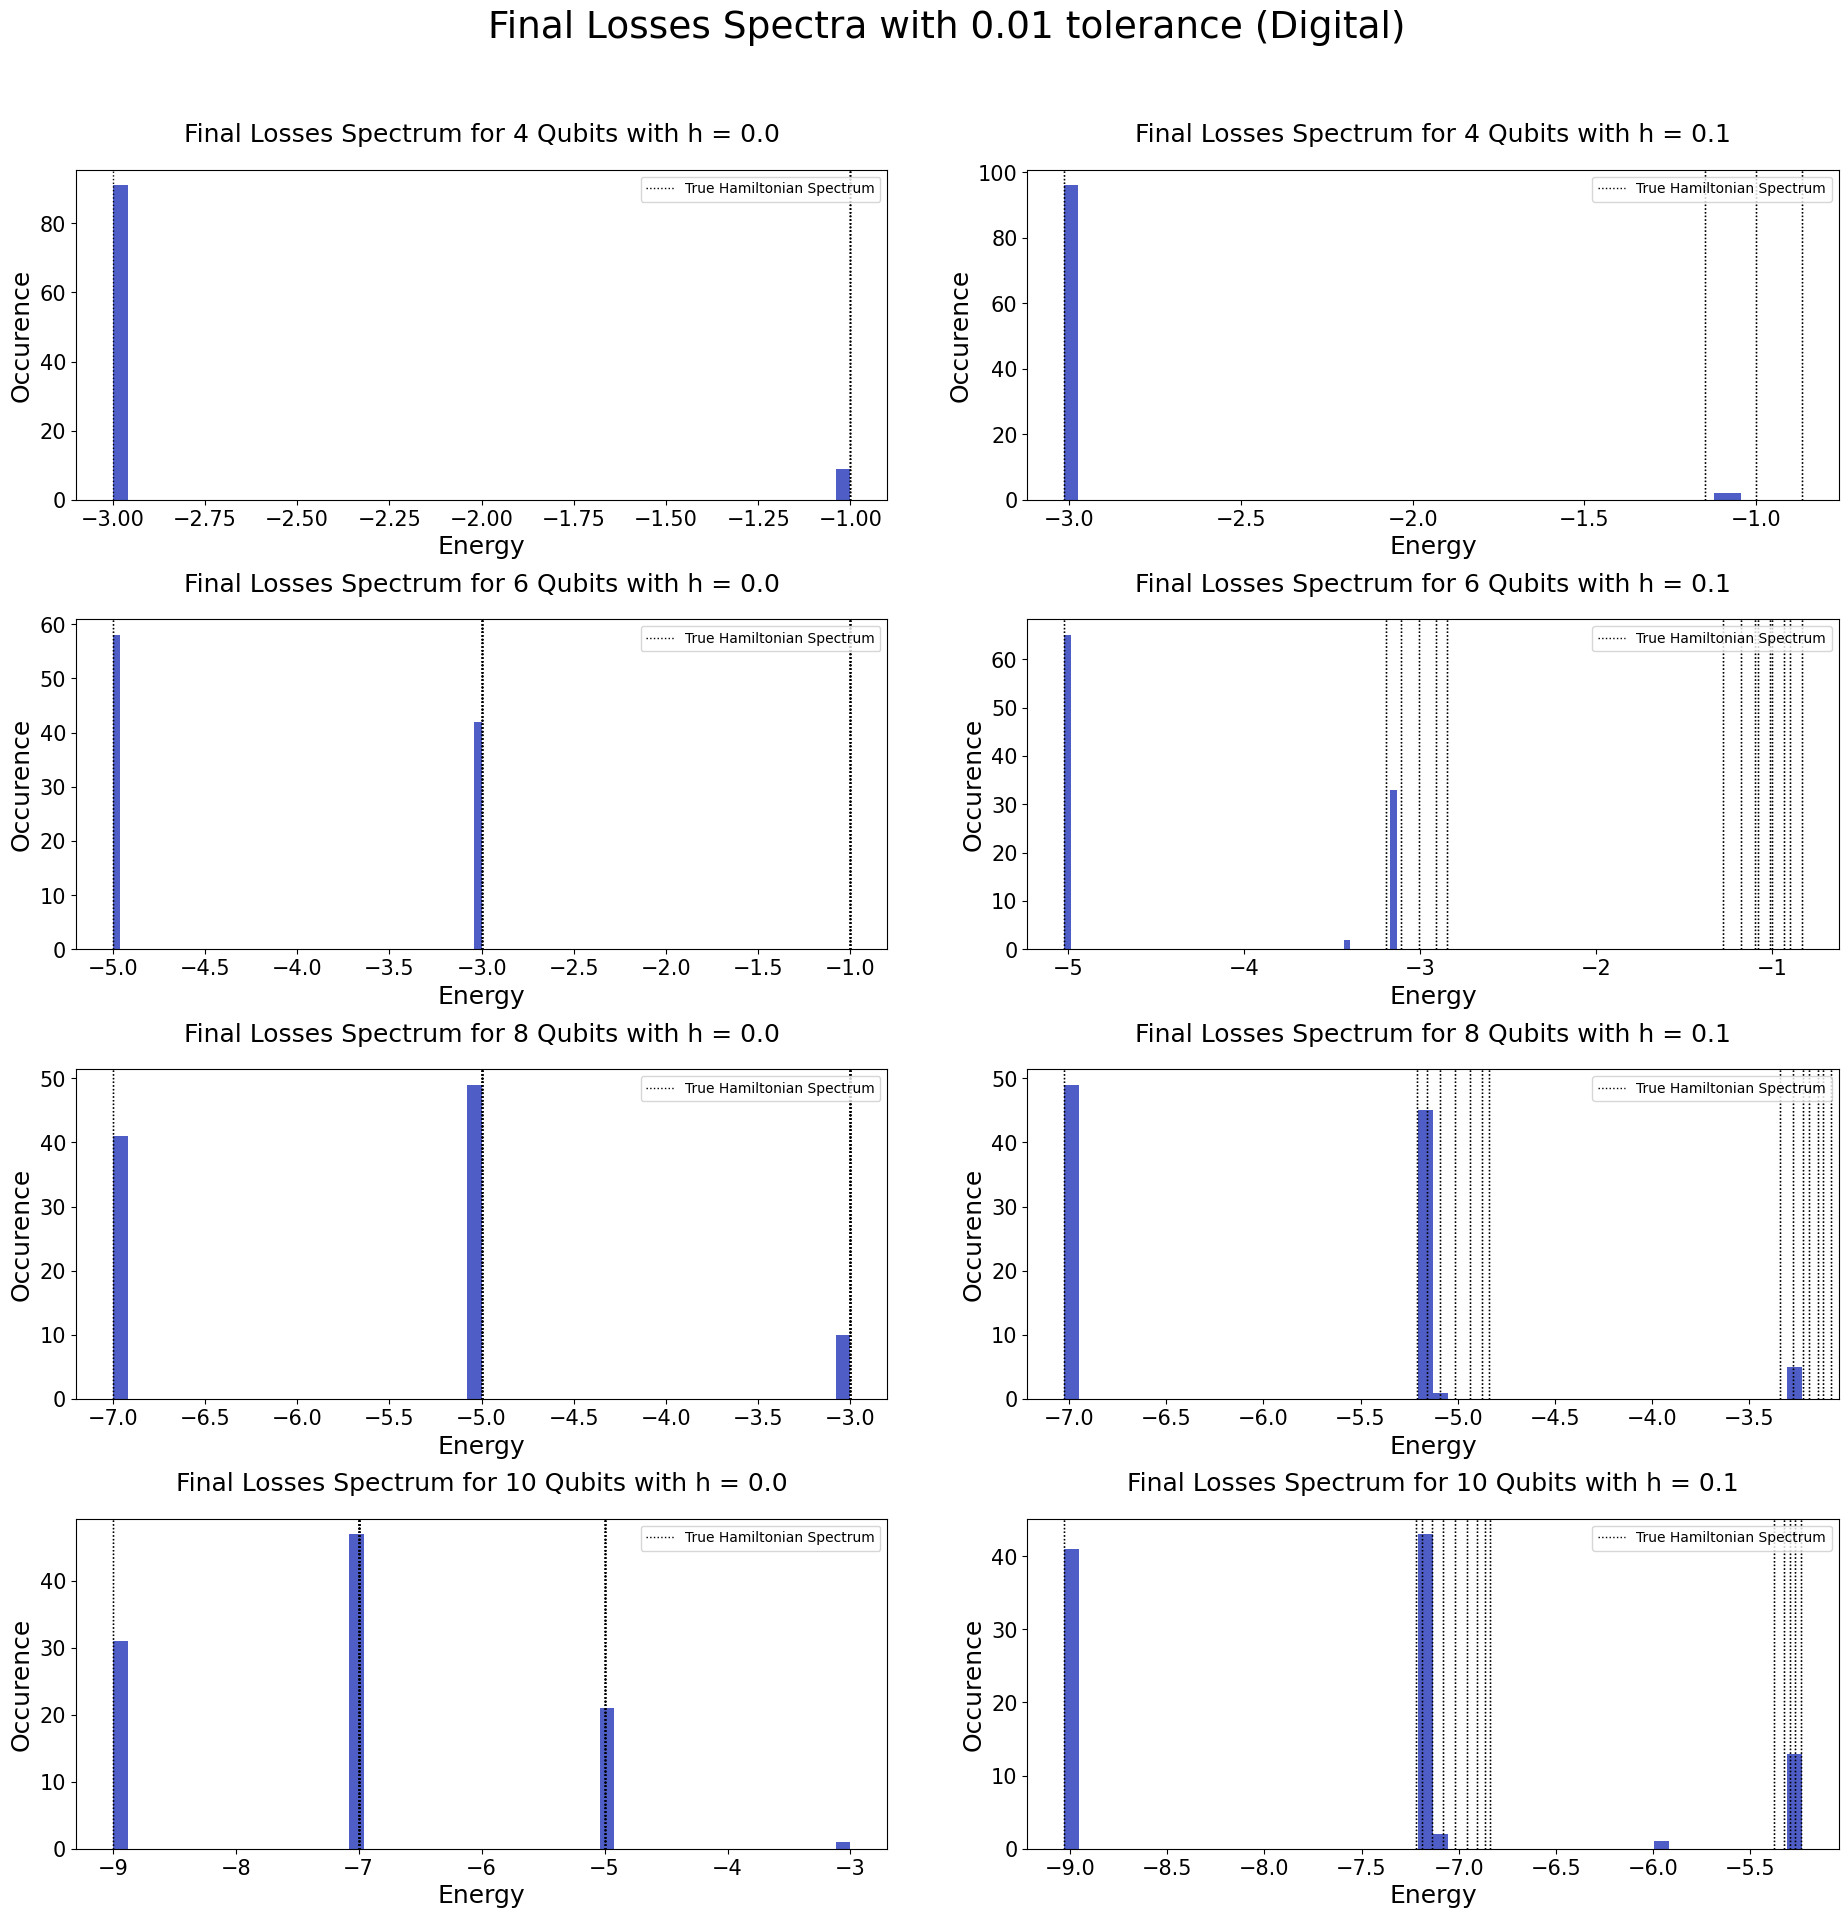

In [9]:

tolerance = 0.01

MOSAIC = """
        AE
        BF
        CG
        DH
        """

ax_mapping = {
    '4_0.0': 'A',
    '4_0.1': 'E',
    '6_0.0': 'B',
    '6_0.1': 'F',
    '8_0.0': 'C',
    '8_0.1': 'G',
    '10_0.0': 'D',
    '10_0.1': 'H',
}


fig, ax_dict = plt.subplot_mosaic(MOSAIC, figsize=(20,20))

fig.tight_layout(pad=7.0)


for problem in vqe_problems:

    n_qubits = problem['qubits']
    depth = problem['depth']
    transverse_field_coefficient = problem['transverse_field_coefficient']

    print(f'{n_qubits} Qubits with h = {transverse_field_coefficient}:')

    simulation_results = problem['simulation_results']

    all_final_parameters = simulation_results['all_final_parameters']
    all_final_costs = simulation_results['all_costs_trajectories'][:,-1]
    all_parameters_trajectories = simulation_results['all_parameters_trajectories']

    # print(simulation_results.keys())

    parameters_dim = len(all_final_parameters[-1])
    trials = problem['trials']

    # print(parameters_dim)

    # print(all_final_costs)

    cuts = []

    for ii in range(trials-1):

        diff = all_final_costs[ii]-all_final_costs[ii+1]
        # print(f'{ii} vs {ii+1}:\n   {diff}')

        if np.abs(diff) > tolerance:
            cuts.append((ii, ii+1))

    # print(cuts)

    print(f'Found spectrum (given a {tolerance} tolerance)')

    split_cuts = [k[-1] for k in cuts]

    costs_split = np.split(all_final_costs, split_cuts)

    parameters_split = np.split(all_final_parameters, split_cuts)

    parameters_trajectories_split =np.split(all_parameters_trajectories, split_cuts)

    simulation_results['final_parameters_split'] = parameters_split

    spectrum_dict = {}

    energies = []
    frequencies = []

    for state in range(len(costs_split)):
        energy = np.mean(costs_split[state][0])
        frequency = len(costs_split[state])

        energies.append(energy)
        frequencies.append(frequency)

        print(f'    {state} excited state:\n        {round(energy,3)} | frequency: {frequency}')


        spectrum_dict[f'{state}_excited_state']= {
            'final_costs': costs_split[state],
            'mean_cost': energy,
            'frequency': frequency,
            'final_parameters': parameters_split[state],
            'parameter_trajectories': parameters_trajectories_split[state],
        }
        
    simulation_results['spectrum_dictionary'] = spectrum_dict

    loss_hamiltonian_spectrum = problem['loss_hamiltonian_spectrum']
    print(f"Real spectrum:\n    {problem['loss_hamiltonian_spectrum']}")

    print(energies)
    print(frequencies)

    # fig, ax = plt.subplots()


    key = f'{n_qubits}_{transverse_field_coefficient}'
    ax_key = ax_mapping[key]
    # print(key)
    ax = ax_dict[ax_key]

    # Plot the histogram
    ax.hist(energies, bins=50, weights=frequencies, align="mid", color=plt.get_cmap("coolwarm", 7)(0), alpha=0.9)

    ax.set_title(f"Final Losses Spectrum for {n_qubits} Qubits with h = {transverse_field_coefficient}", fontsize=title_fontsize, pad=20)
    ax.set_xlabel("Energy", fontsize=label_fontsize)
    ax.set_ylabel("Occurence", fontsize=label_fontsize)
    ax.tick_params(labelsize=tick_fontsize)


    qubits_folder = results_path + f'{n_qubits} qubits/'

    create_folder(qubits_folder)
    
    filename = qubits_folder + f'final_spectrum_{n_qubits}qubits_{depth}depth_{transverse_field_coefficient}transverse_field.pdf'

    spectrum_lines = np.unique(loss_hamiltonian_spectrum)
    for state in range(len(spectrum_lines)):

        line = spectrum_lines[state]

        if state == 0:
            # label = 'Ground State'
            label = 'True Hamiltonian Spectrum'
        else:
            # label = f"{state} Excited State"
            label = ''

        ax.axvline(x = line, color = 'black', label = label, linestyle = ':', linewidth=1)

    # ax.set_xlim(loss_limits)

    ax.legend(loc='upper right')




fig.suptitle(f"Final Losses Spectra with {tolerance} tolerance (Digital)", fontsize=title_fontsize*1.5)

plt.subplots_adjust(top=0.9)

# plt.tight_layout()

# plt.tight_layout()


filename = results_path + 'final_losses_spectrum_with_tolerance.pdf'


plt.savefig(filename, bbox_inches="tight")


## Statistics

In [10]:
from scipy.spatial.distance import pdist

def distance_statistics(parameter_trajectories, hilbert_dimension):
    training_distances = []
    for trajectory in parameter_trajectories:
        training_distance = np.linalg.norm(trajectory[0] - trajectory[-1])
        training_distance = training_distance/hilbert_dimension
        training_distances.append(training_distance)

    training_distances = np.asarray(training_distances)

    # final_parameters = parameter_trajectories[:,-1]
    # statistics:

    training_mean = np.mean(training_distances)
    training_median = np.median(training_distances)
    training_std = np.std(training_distances)

    print('\n     Training Distance Statistics:\n')
    print(f'        Mean training distance: {training_mean}')
    print(f'        Median training distance: {training_median}')
    print(f'        Standard deviation of the training distance: {training_std}')

    final_parameters = parameter_trajectories[:,-1]

    inner_distances = pdist(final_parameters)/hilbert_dimension

    inner_mean = np.mean(inner_distances)
    inner_median = np.median(inner_distances)
    inner_std = np.std(inner_distances)

    print('\n     Distances Between Minima Statistics:\n')
    print(f'        Mean distance between minima: {inner_mean}')
    print(f'        Median distance between minima: {inner_median}')
    print(f'        Standard deviation of the distance between minima: {inner_std}')


    return training_distances, training_mean, training_median, training_std, inner_distances, inner_mean, inner_median, inner_std

In [11]:
for problem in vqe_problems:

        
    n_qubits = problem['qubits']

    transverse_field_coefficient = problem['transverse_field_coefficient']

    print(f'{n_qubits} Qubits with h = {transverse_field_coefficient}:')

    simulation_results = problem['simulation_results']
    all_parameters_trajectories = simulation_results['all_parameters_trajectories']

    # Average training distance


    spectrum_dict = simulation_results['spectrum_dictionary']

    for state in spectrum_dict.keys():
        print(f'\n    {state}')
        parameter_trajectories = spectrum_dict[state]['parameter_trajectories']
        training_distances, training_mean, training_median, training_std, inner_distances, inner_mean, inner_median, inner_std = distance_statistics(parameter_trajectories, 2**n_qubits)
        spectrum_dict[state]['training_distance_statistics'] = {
            'distances': training_distances,
            'mean': training_mean,
            'median': training_median,
            'std': training_std
        }
        spectrum_dict[state]['distance_between_minima_statistics'] = {
            'distances': inner_distances,
            'mean': inner_mean,
            'median': inner_median,
            'std': inner_std
        }




4 Qubits with h = 0.0:

    0_excited_state

     Training Distance Statistics:

        Mean training distance: 0.08590314631252963
        Median training distance: 0.08640561767249136
        Standard deviation of the training distance: 0.011434100811741524

     Distances Between Minima Statistics:

        Mean distance between minima: 0.25297936151728895
        Median distance between minima: 0.25544635557150747
        Standard deviation of the distance between minima: 0.02334250782698133

    1_excited_state

     Training Distance Statistics:

        Mean training distance: 0.05691383778234189
        Median training distance: 0.05988866659911171
        Standard deviation of the training distance: 0.00904904121046527

     Distances Between Minima Statistics:

        Mean distance between minima: 0.246522913968724
        Median distance between minima: 0.2525399655997056
        Standard deviation of the distance between minima: 0.021443844085349054
6 Qubits with h = 0.0:

/Users/jorgegarciaponce/Research/Yelin/Perceptron/CumulantNODEs/perceptron_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jorgegarciaponce/Research/Yelin/Perceptron/CumulantNODEs/perceptron_venv/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jorgegarciaponce/Research/Yelin/Perceptron/CumulantNODEs/perceptron_venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jorgegarciaponce/Research/Yelin/Perceptron/CumulantNODEs/perceptron_venv/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jorgegarciaponce/Resea

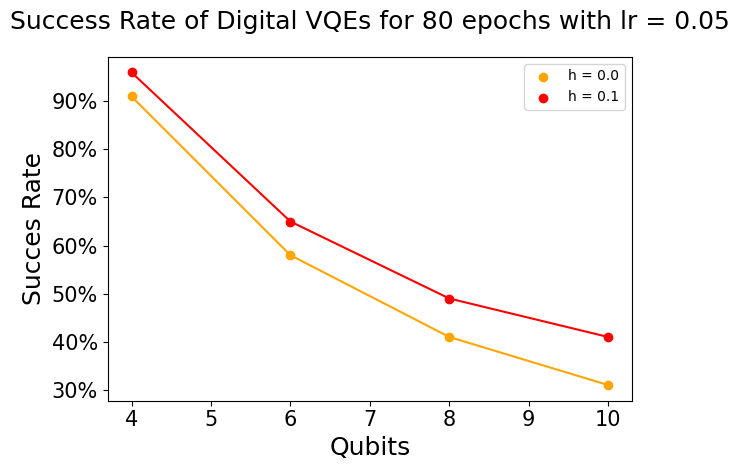

In [12]:
# Ground State Convergence statistics:
from matplotlib.ticker import PercentFormatter


lowest_energies = []
mean_energies = []
frequencies = []
qubit_number = []
transverse_fields = []

for problem in vqe_problems:

    n_qubits = problem['qubits']
    h_parameter = problem['transverse_field_coefficient']

    simulation_results = problem['simulation_results']
    spectrum_dict = simulation_results['spectrum_dictionary']

    # Ground State Data

    ground_state_data = spectrum_dict['0_excited_state']
    # training_distance_statistics = ground_state_data['training_distance_statistics']

    ground_state_energy = ground_state_data['final_costs'][0]
    mean_ground_state_energy = ground_state_data['mean_cost']
    frequency = ground_state_data['frequency']

    lowest_energies.append(ground_state_energy)
    mean_energies.append(mean_ground_state_energy)
    frequencies.append(frequency)
    qubit_number.append(n_qubits)
    transverse_fields.append(h_parameter)


fig, ax = plt.subplots()


frequencies = np.asarray(frequencies)/100
transverse_fields = np.asarray(transverse_fields)
qubit_number = np.asarray(qubit_number)

field_filter = np.where(transverse_fields==0.0, True, False)


# colors = np.where(transverse_fields==0.1, 'red', 'blue')

# 0.0 Field
ax.scatter(qubit_number[field_filter], frequencies[field_filter], c='orange', label = 'h = 0.0')
ax.plot(qubit_number[field_filter], frequencies[field_filter], c='orange')

# 0.1 Field

ax.scatter(qubit_number[~field_filter], frequencies[~field_filter], c='red', label = 'h = 0.1')
ax.plot(qubit_number[~field_filter], frequencies[~field_filter], c='red')

ax.set_ylabel('Succes Rate', fontsize=label_fontsize)
ax.set_xlabel('Qubits', fontsize=label_fontsize)
ax.set_title(f'Success Rate of Digital VQEs for 80 epochs with lr = 0.05', fontsize=label_fontsize, pad=20)
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.tick_params(labelsize=tick_fontsize)


ax.legend(loc='upper right')

plt.tight_layout()

filename = results_path + 'success_rate_plot.pdf'


plt.savefig(filename, bbox_inches="tight")


# print(frequencies)

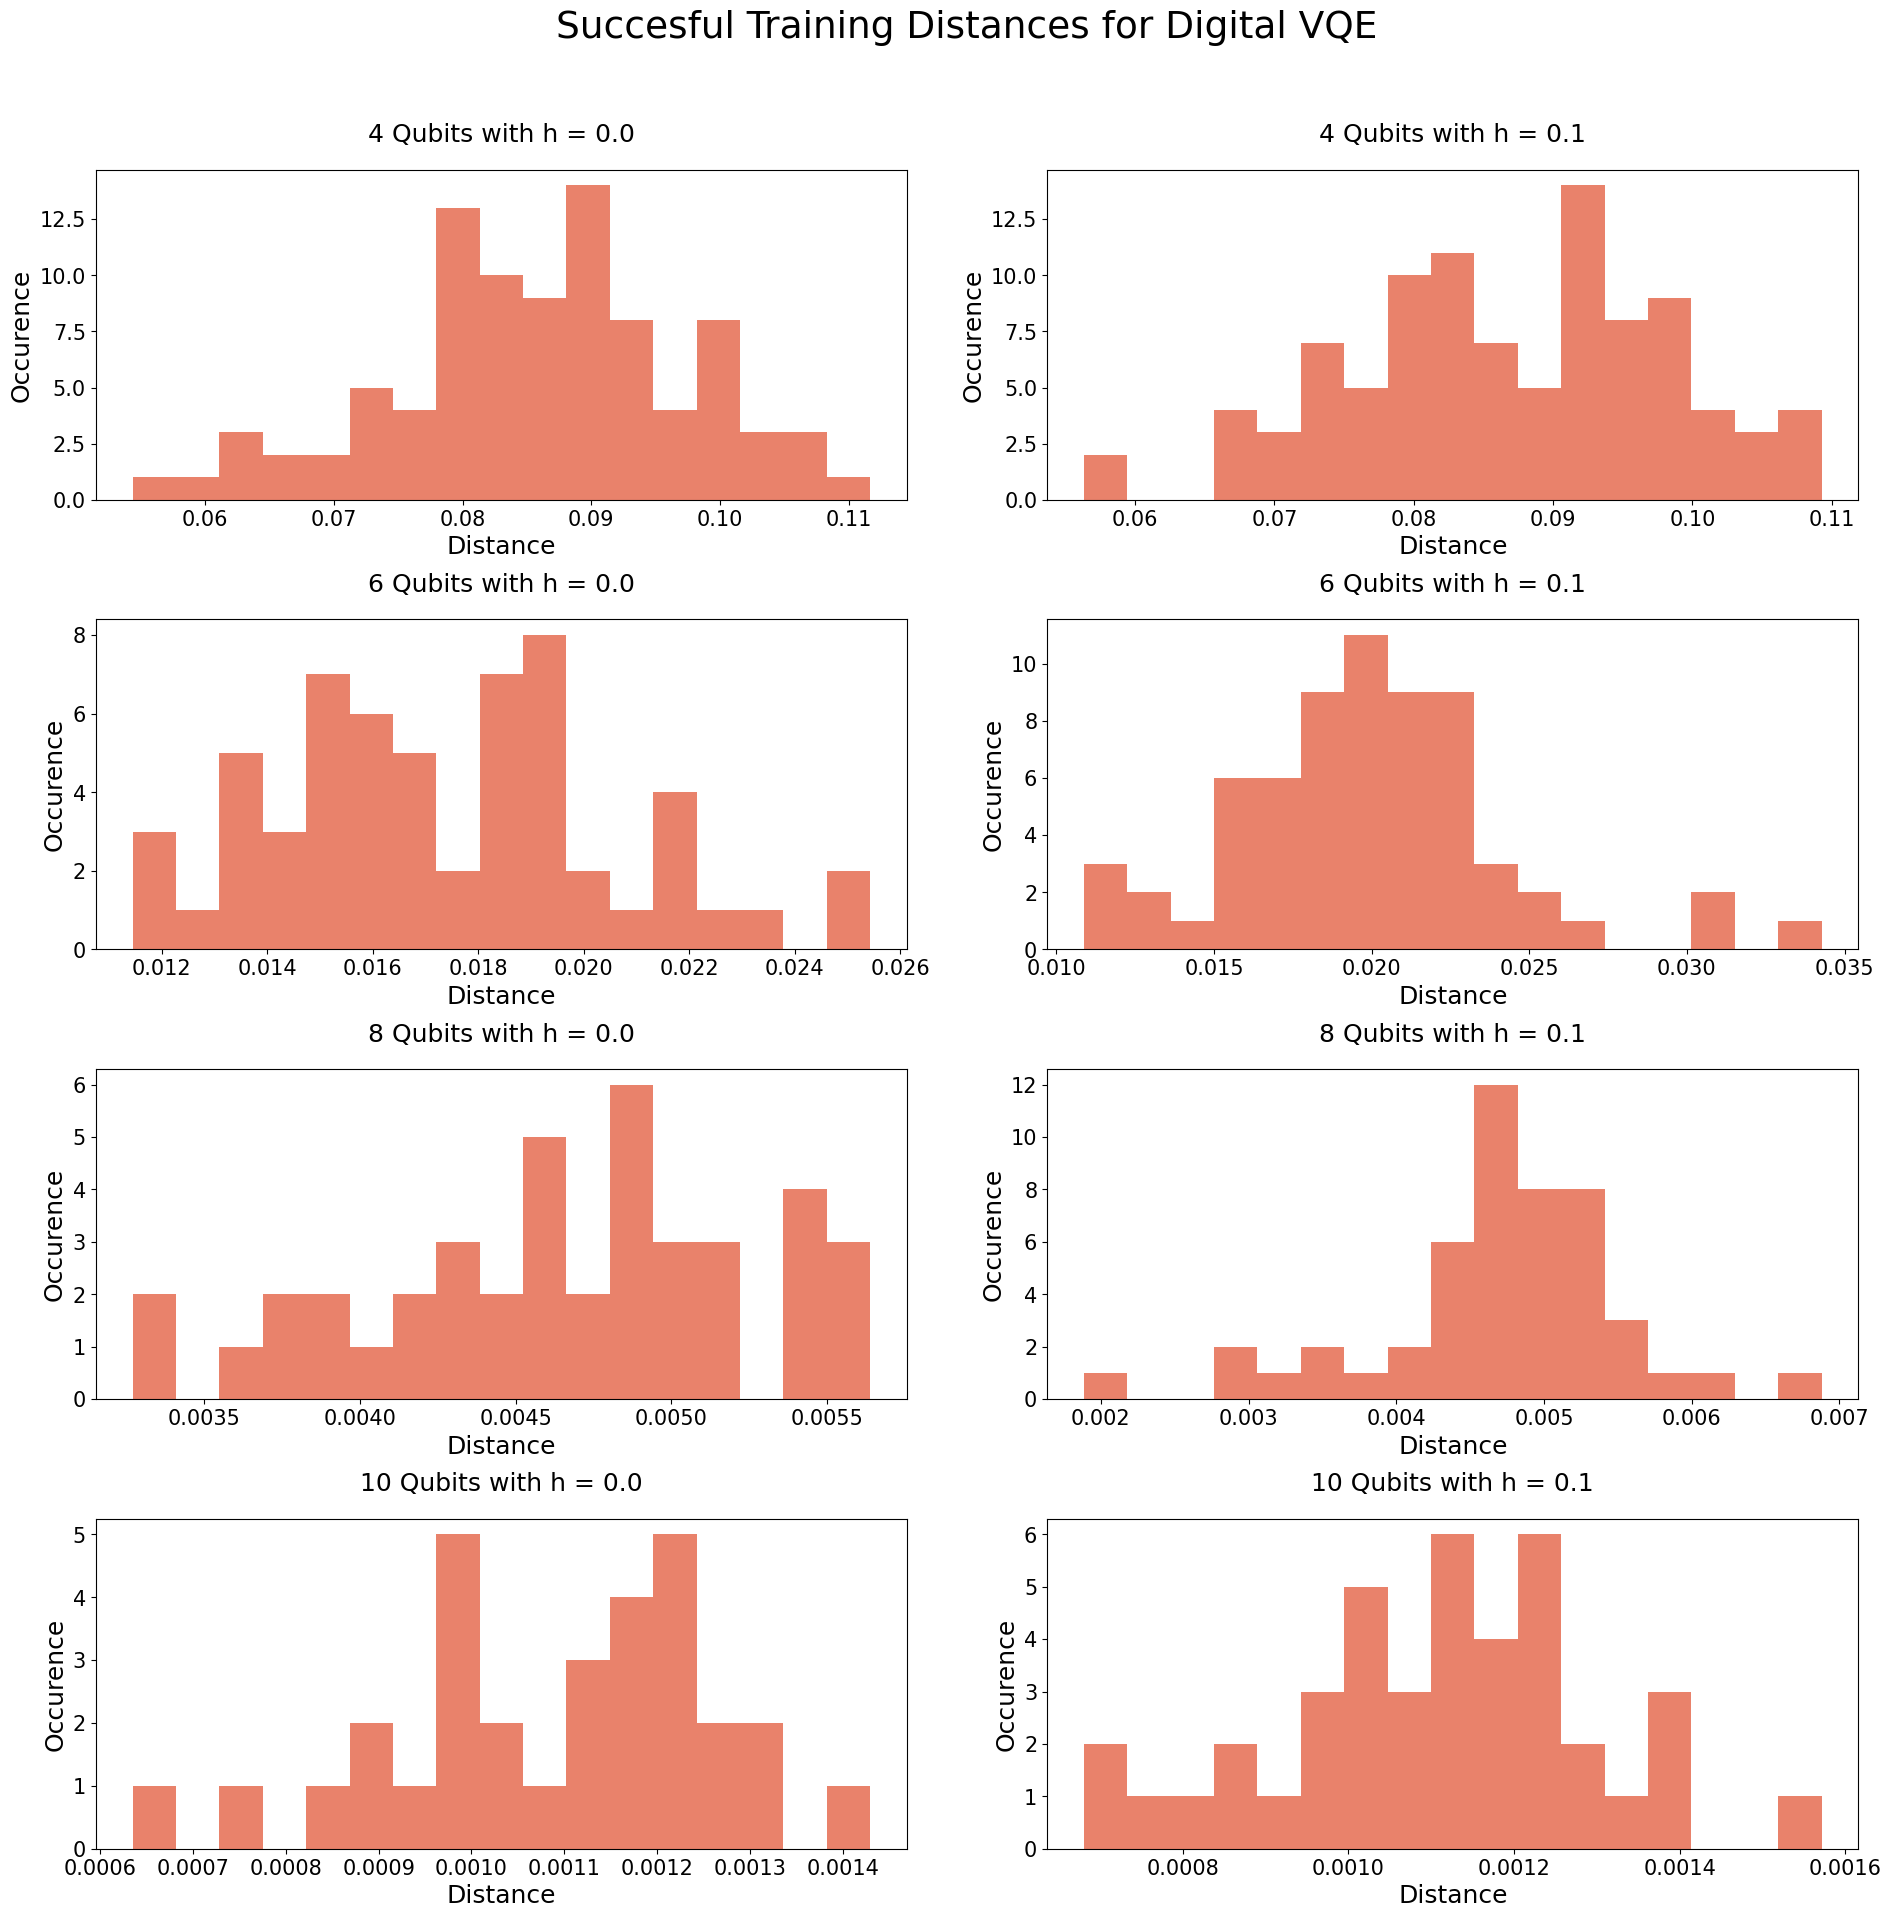

In [13]:
# Training Distance Statistics
MOSAIC = """
        AE
        BF
        CG
        DH
        """

ax_mapping = {
    '4_0.0': 'A',
    '4_0.1': 'E',
    '6_0.0': 'B',
    '6_0.1': 'F',
    '8_0.0': 'C',
    '8_0.1': 'G',
    '10_0.0': 'D',
    '10_0.1': 'H',
}


std_training_distances = []
mean_training_distances = []
# frequencies = []
qubit_number = []
transverse_fields = []



fig_training, ax_dict_training = plt.subplot_mosaic(MOSAIC, figsize=(20,20))

fig_training.tight_layout(pad=7.0)


for problem in vqe_problems:

    n_qubits = problem['qubits']
    h_parameter = problem['transverse_field_coefficient']

    qubit_number.append(n_qubits)
    transverse_fields.append(h_parameter)

    simulation_results = problem['simulation_results']
    spectrum_dict = simulation_results['spectrum_dictionary']

    ground_state_data = spectrum_dict['0_excited_state']
    training_distance_statistics = ground_state_data['training_distance_statistics']

    ground_state_energy = ground_state_data['final_costs'][0]
    mean_ground_state_energy = ground_state_data['mean_cost']
    frequency = ground_state_data['frequency']

    training_distances = training_distance_statistics['distances']
    average_training_distance = training_distance_statistics['mean']
    median_training_distance = training_distance_statistics['median']
    std_training_distance = training_distance_statistics['std']

    mean_training_distances.append(average_training_distance)
    std_training_distances.append(std_training_distance)

    # print(training_distances)

    # fig, ax = plt.subplots()

    key = f'{n_qubits}_{h_parameter}'
    ax_key = ax_mapping[key]
    ax = ax_dict_training[ax_key]

    ax.hist(training_distances, bins=17, align="mid", color=plt.get_cmap("coolwarm", 7)(5), alpha=0.9)
    # ax.set_title(f"Succesful Training Distances for {n_qubits} Qubits with h = {h_parameter} (Digital)", fontsize=title_fontsize, pad=20)
    ax.set_title(f"{n_qubits} Qubits with h = {h_parameter}", fontsize=title_fontsize, pad=20)
    ax.set_xlabel("Distance", fontsize=label_fontsize)
    ax.set_ylabel("Occurence", fontsize=label_fontsize)
    ax.tick_params(labelsize=tick_fontsize)



fig_training.suptitle(f"Succesful Training Distances for Digital VQE", fontsize=title_fontsize*1.5)

plt.subplots_adjust(top=0.9)


# plt.tight_layout()


filename = results_path + 'training_distances_histograms.pdf'


plt.savefig(filename, bbox_inches="tight")





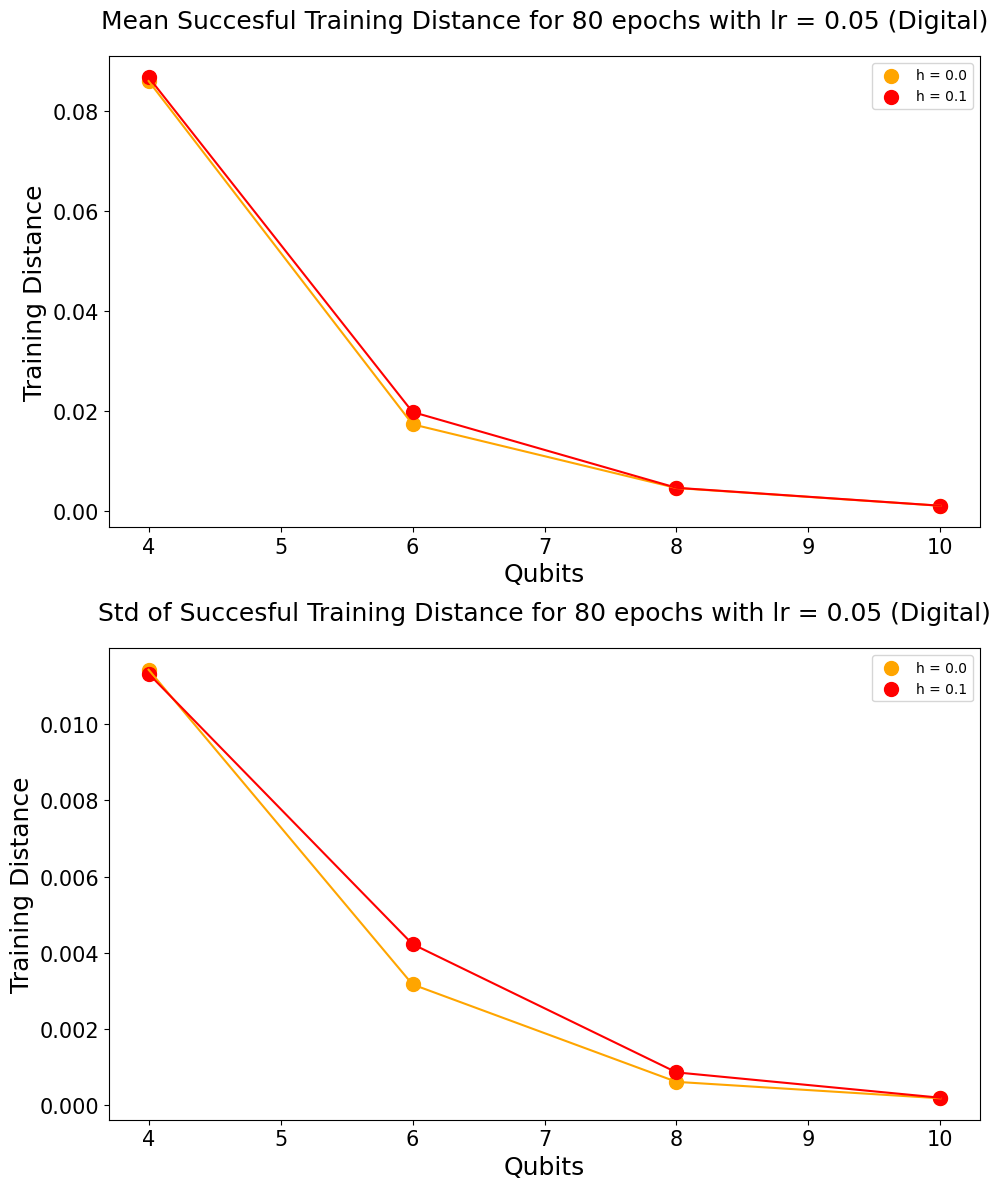

In [14]:

MOSAIC = """
        A
        B
        """


# frequencies = np.asarray(frequencies)/100
transverse_fields = np.asarray(transverse_fields)
qubit_number = np.asarray(qubit_number)
std_training_distances = np.asarray(std_training_distances)
mean_training_distances = np.asarray(mean_training_distances)

###############################
# Mean and Std plots


fig, ax_dict = plt.subplot_mosaic(MOSAIC, figsize=(10,12))


fig.tight_layout(pad=7.0)


# frequencies = np.asarray(frequencies)/100
transverse_fields = np.asarray(transverse_fields)
qubit_number = np.asarray(qubit_number)

field_filter = np.where(transverse_fields==0.0, True, False)


# colors = np.where(transverse_fields==0.1, 'red', 'blue')

# 0.0 Field

ax_mean = ax_dict['A']

ax_mean.scatter(qubit_number[field_filter], mean_training_distances[field_filter], s=100, c='orange', label = 'h = 0.0')
ax_mean.plot(qubit_number[field_filter], mean_training_distances[field_filter], c='orange')

# 0.1 Field

ax_mean.scatter(qubit_number[~field_filter], mean_training_distances[~field_filter], s=100, c='red', label = 'h = 0.1')
ax_mean.plot(qubit_number[~field_filter], mean_training_distances[~field_filter], c='red')

ax_mean.set_ylabel('Training Distance', fontsize=label_fontsize)
ax_mean.set_xlabel('Qubits', fontsize=label_fontsize)
ax_mean.set_title(f'Mean Succesful Training Distance for 80 epochs with lr = 0.05 (Digital)', fontsize=label_fontsize, pad=20)
# ax_mean.yaxis.set_major_formatter(PercentFormatter(1))
ax_mean.tick_params(labelsize=tick_fontsize)

ax_std = ax_dict['B']


ax_std.scatter(qubit_number[field_filter], std_training_distances[field_filter], s=100, c='orange', label = 'h = 0.0')
ax_std.plot(qubit_number[field_filter], std_training_distances[field_filter], c='orange')


# 0.1 Field

ax_std.scatter(qubit_number[~field_filter], std_training_distances[~field_filter], s=100, c='red', label = 'h = 0.1')
ax_std.plot(qubit_number[~field_filter], std_training_distances[~field_filter], c='red')

ax_std.set_ylabel('Training Distance', fontsize=label_fontsize)
ax_std.set_xlabel('Qubits', fontsize=label_fontsize)
ax_std.set_title(f'Std of Succesful Training Distance for 80 epochs with lr = 0.05 (Digital)', fontsize=label_fontsize, pad=20)
# ax_mean.yaxis.set_major_formatter(PercentFormatter(1))
ax_std.tick_params(labelsize=tick_fontsize)


ax_std.legend()
ax_mean.legend()

plt.tight_layout()


filename = results_path + 'training_distances_statistics_plots.pdf'


plt.savefig(filename, bbox_inches="tight")



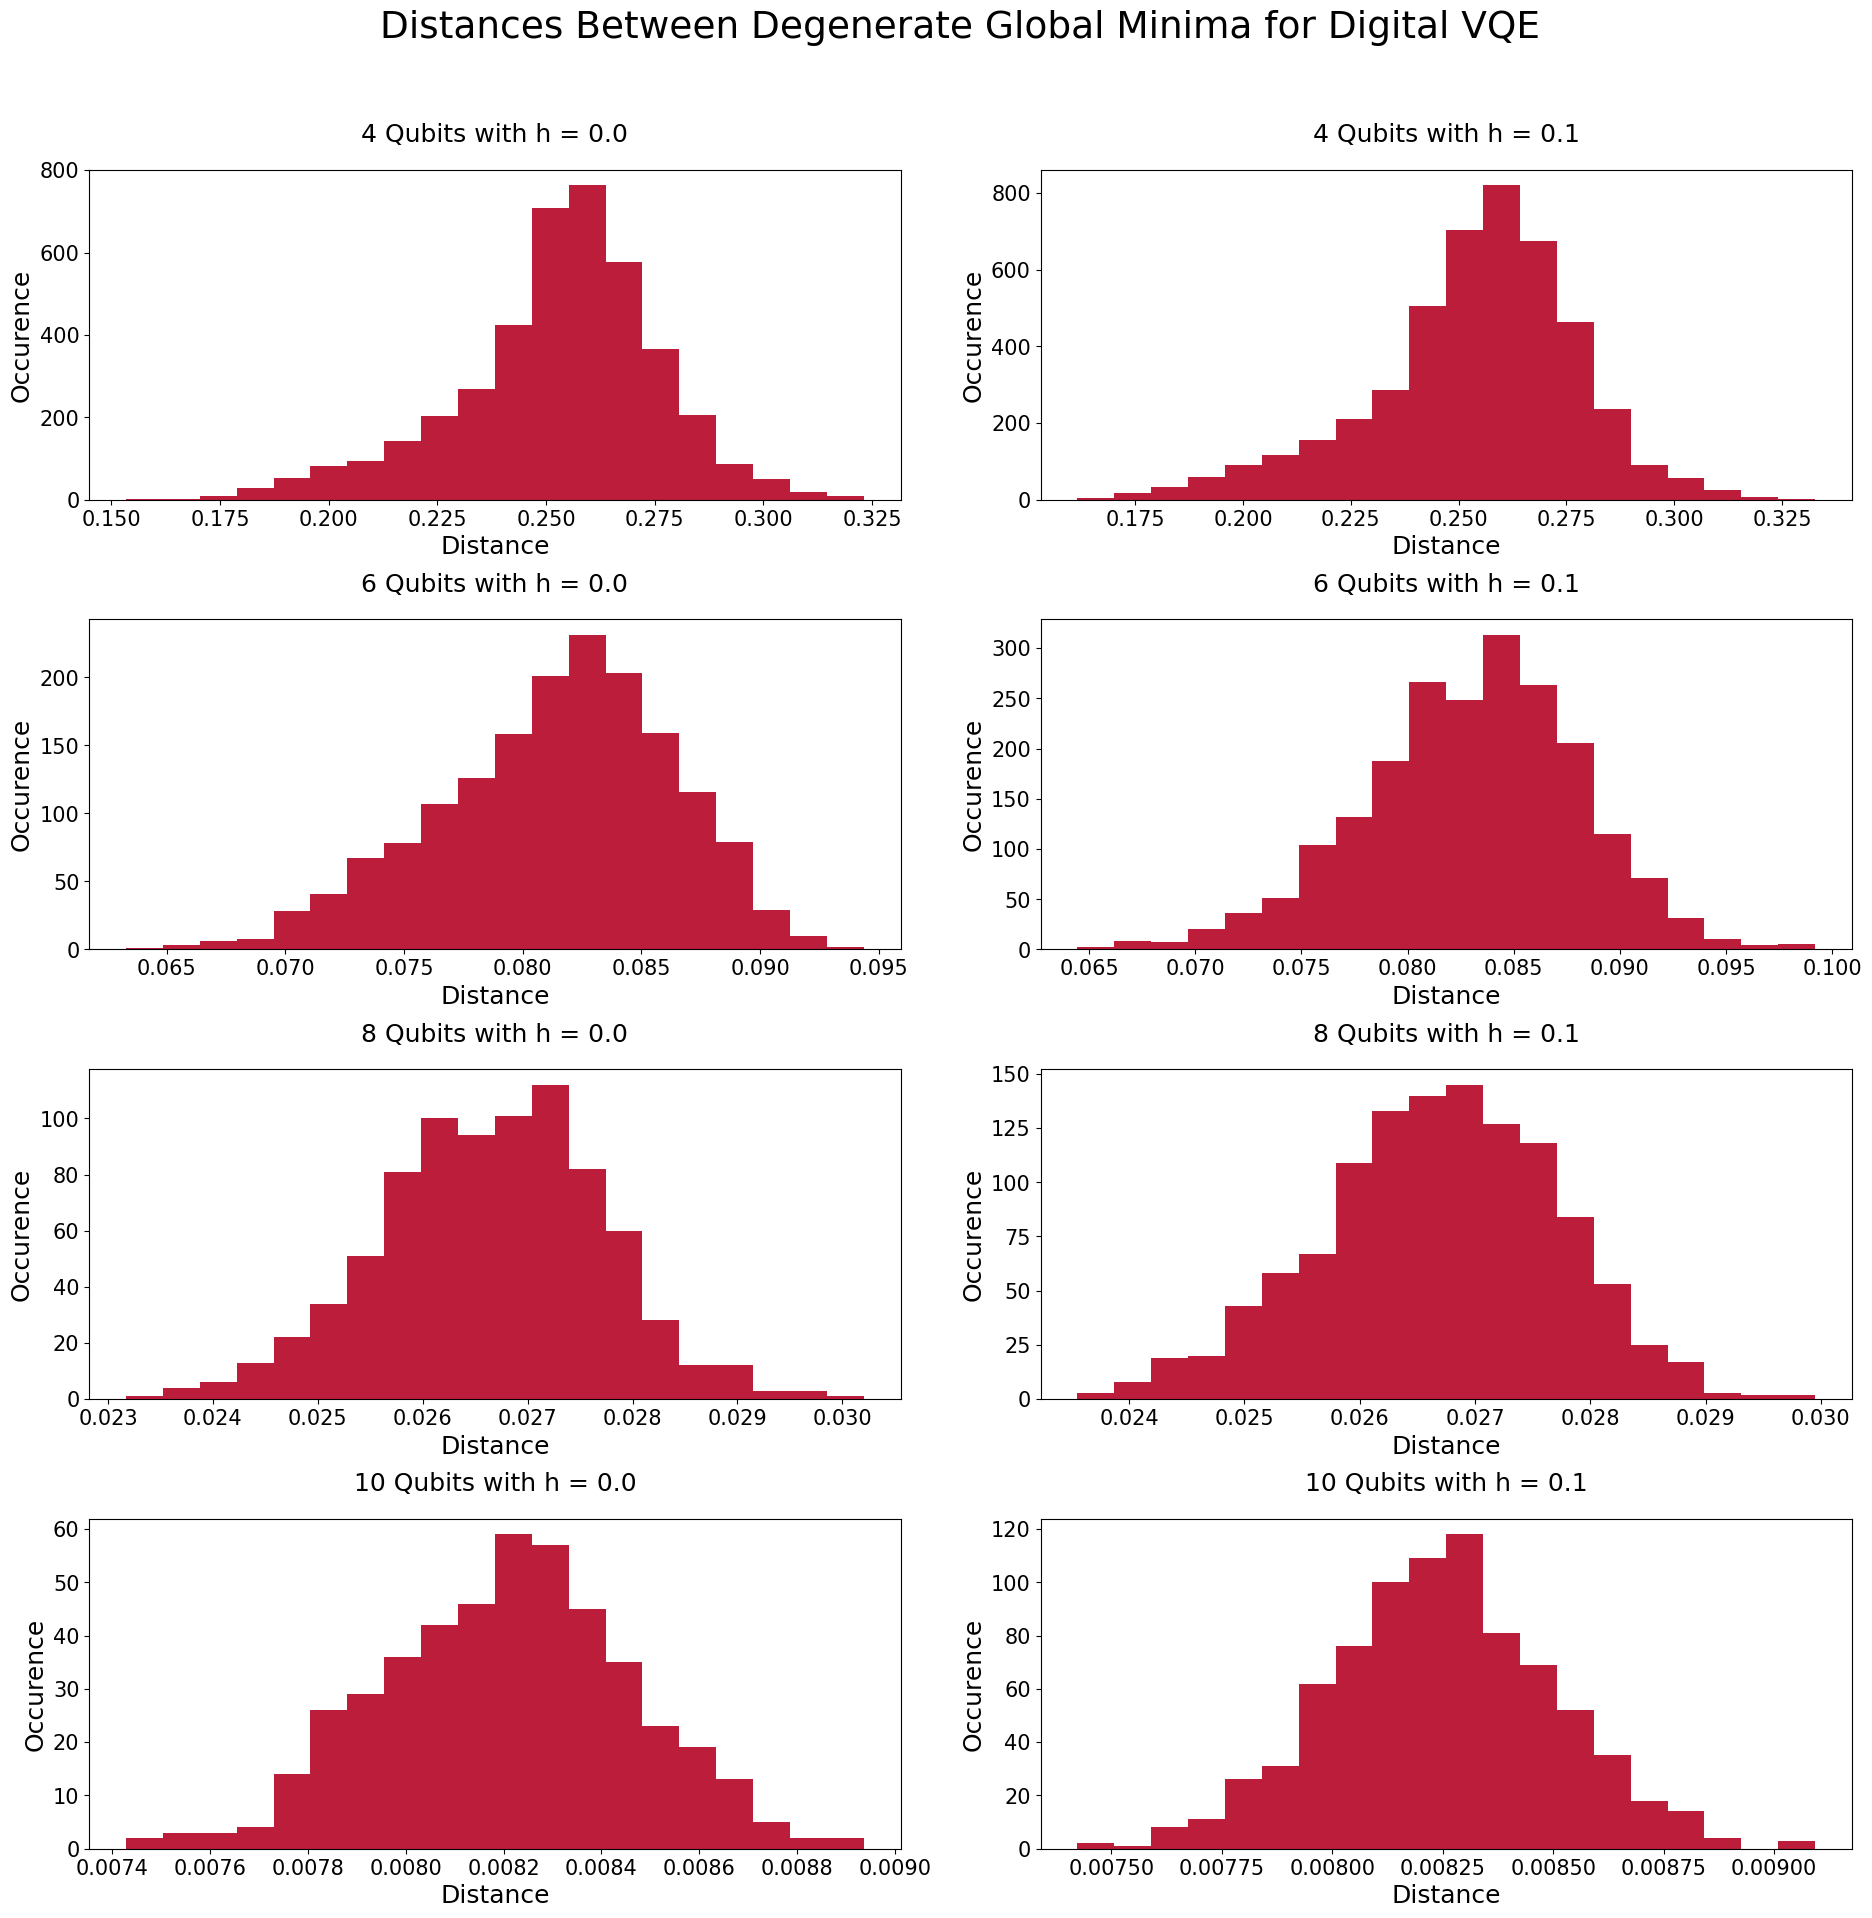

In [15]:
# Distance between minima Statistics
MOSAIC = """
        AE
        BF
        CG
        DH
        """

ax_mapping = {
    '4_0.0': 'A',
    '4_0.1': 'E',
    '6_0.0': 'B',
    '6_0.1': 'F',
    '8_0.0': 'C',
    '8_0.1': 'G',
    '10_0.0': 'D',
    '10_0.1': 'H',
}


std_inner_distances = []
mean_inner_distances = []
# frequencies = []
qubit_number = []
transverse_fields = []



fig, ax_dict = plt.subplot_mosaic(MOSAIC, figsize=(20,20))

fig.tight_layout(pad=7.0)


for problem in vqe_problems:

    n_qubits = problem['qubits']
    h_parameter = problem['transverse_field_coefficient']

    qubit_number.append(n_qubits)
    transverse_fields.append(h_parameter)

    simulation_results = problem['simulation_results']
    spectrum_dict = simulation_results['spectrum_dictionary']

    ground_state_data = spectrum_dict['0_excited_state']
    distance_between_minima_statistics = ground_state_data['distance_between_minima_statistics']

    ground_state_energy = ground_state_data['final_costs'][0]
    mean_ground_state_energy = ground_state_data['mean_cost']
    frequency = ground_state_data['frequency']

    inner_distances = distance_between_minima_statistics['distances']
    average_distance = distance_between_minima_statistics['mean']
    median_distance = distance_between_minima_statistics['median']
    std_distance = distance_between_minima_statistics['std']

    mean_inner_distances.append(average_distance)
    std_inner_distances.append(std_distance)

    # fig, ax = plt.subplots()

    key = f'{n_qubits}_{h_parameter}'
    ax_key = ax_mapping[key]
    # print(key)
    ax = ax_dict[ax_key]
    # print(ax)

    # print(inner_distances)
    # print(average_distance)

    # print(inner_distances)

    ax.hist(inner_distances, bins = 20, align="mid", color=plt.get_cmap("coolwarm", 7)(9), alpha=0.9)
    # ax.set_title(f"Succesful Training Distances for {n_qubits} Qubits with h = {h_parameter} (Digital)", fontsize=title_fontsize, pad=20)
    ax.set_title(f"{n_qubits} Qubits with h = {h_parameter}", fontsize=title_fontsize, pad=20)
    ax.set_xlabel("Distance", fontsize=label_fontsize)
    ax.set_ylabel("Occurence", fontsize=label_fontsize)
    ax.tick_params(labelsize=tick_fontsize)



fig.suptitle(f"Distances Between Degenerate Global Minima for Digital VQE", fontsize=title_fontsize*1.5)

plt.subplots_adjust(top=0.9)

# plt.show()
# # plt.tight_layout()


filename = results_path + 'distances_between_degenerate_global_minima_histograms.pdf'


plt.savefig(filename, bbox_inches="tight")




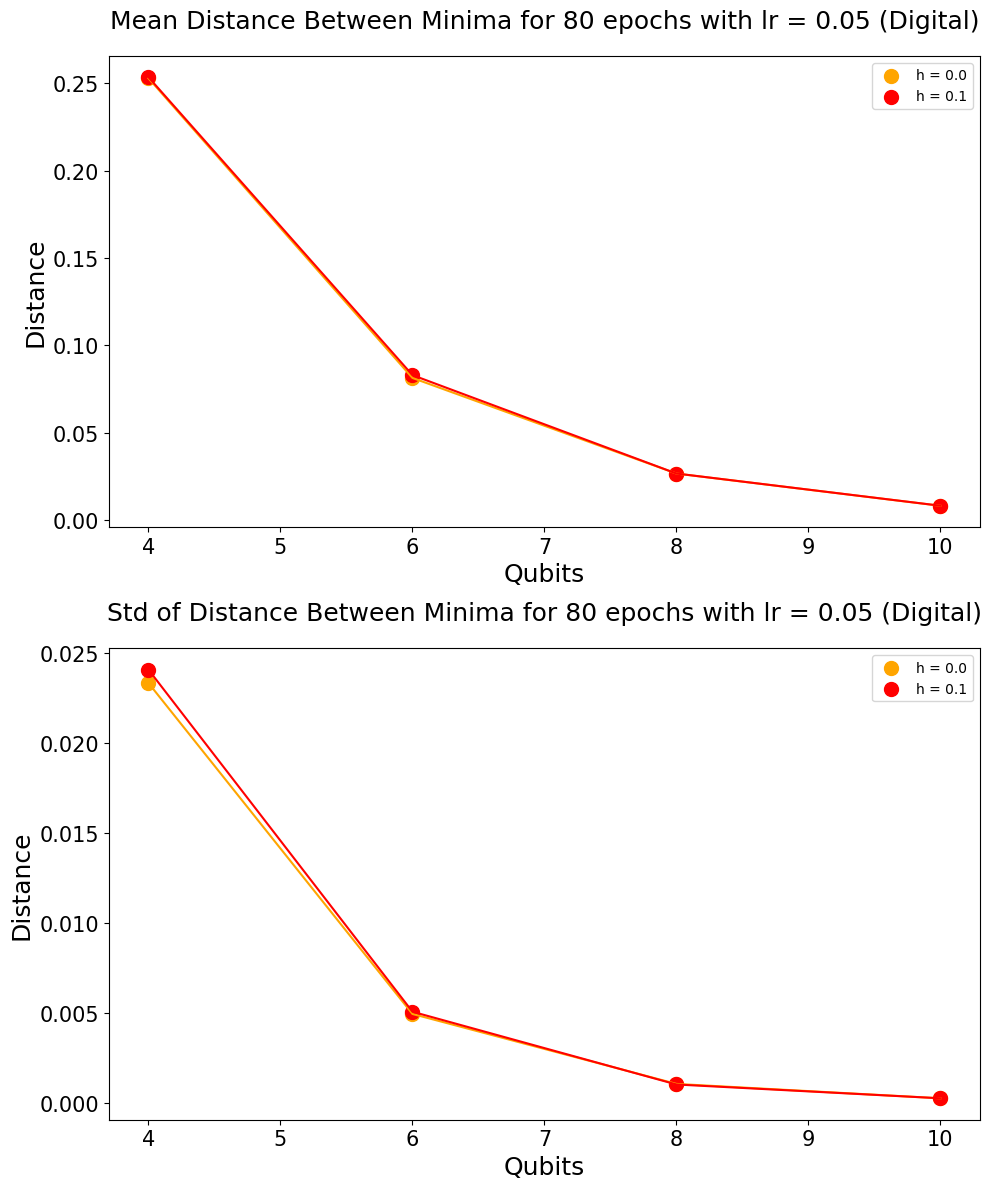

In [16]:
MOSAIC = """
        A
        B
        """


# frequencies = np.asarray(frequencies)/100
transverse_fields = np.asarray(transverse_fields)
qubit_number = np.asarray(qubit_number)
std_inner_distances = np.asarray(std_inner_distances)
mean_inner_distances = np.asarray(mean_inner_distances)

###############################
# Mean and Std plots


fig, ax_dict = plt.subplot_mosaic(MOSAIC, figsize=(10,12))


fig.tight_layout(pad=7.0)


# frequencies = np.asarray(frequencies)/100
transverse_fields = np.asarray(transverse_fields)
qubit_number = np.asarray(qubit_number)

field_filter = np.where(transverse_fields==0.0, True, False)


# colors = np.where(transverse_fields==0.1, 'red', 'blue')

# 0.0 Field

ax_mean = ax_dict['A']

ax_mean.scatter(qubit_number[field_filter], mean_inner_distances[field_filter], s=100, c='orange', label = 'h = 0.0')
ax_mean.plot(qubit_number[field_filter], mean_inner_distances[field_filter], c='orange')

# 0.1 Field

ax_mean.scatter(qubit_number[~field_filter], mean_inner_distances[~field_filter], s=100, c='red', label = 'h = 0.1')
ax_mean.plot(qubit_number[~field_filter], mean_inner_distances[~field_filter], c='red')

ax_mean.set_ylabel('Distance', fontsize=label_fontsize)
ax_mean.set_xlabel('Qubits', fontsize=label_fontsize)
ax_mean.set_title(f'Mean Distance Between Minima for 80 epochs with lr = 0.05 (Digital)', fontsize=label_fontsize, pad=20)
# ax_mean.yaxis.set_major_formatter(PercentFormatter(1))
ax_mean.tick_params(labelsize=tick_fontsize)

ax_std = ax_dict['B']


ax_std.scatter(qubit_number[field_filter], std_inner_distances[field_filter], s=100, c='orange', label = 'h = 0.0')
ax_std.plot(qubit_number[field_filter], std_inner_distances[field_filter], c='orange')


# 0.1 Field

ax_std.scatter(qubit_number[~field_filter], std_inner_distances[~field_filter], s=100, c='red', label = 'h = 0.1')
ax_std.plot(qubit_number[~field_filter], std_inner_distances[~field_filter], c='red')

ax_std.set_ylabel('Distance', fontsize=label_fontsize)
ax_std.set_xlabel('Qubits', fontsize=label_fontsize)
ax_std.set_title(f'Std of Distance Between Minima for 80 epochs with lr = 0.05 (Digital)', fontsize=label_fontsize, pad=20)
# ax_mean.yaxis.set_major_formatter(PercentFormatter(1))
ax_std.tick_params(labelsize=tick_fontsize)


ax_std.legend()
ax_mean.legend()

plt.tight_layout()


filename = results_path + 'distances_between_degenerate_global_minima_statistics.pdf'


plt.savefig(filename, bbox_inches="tight")



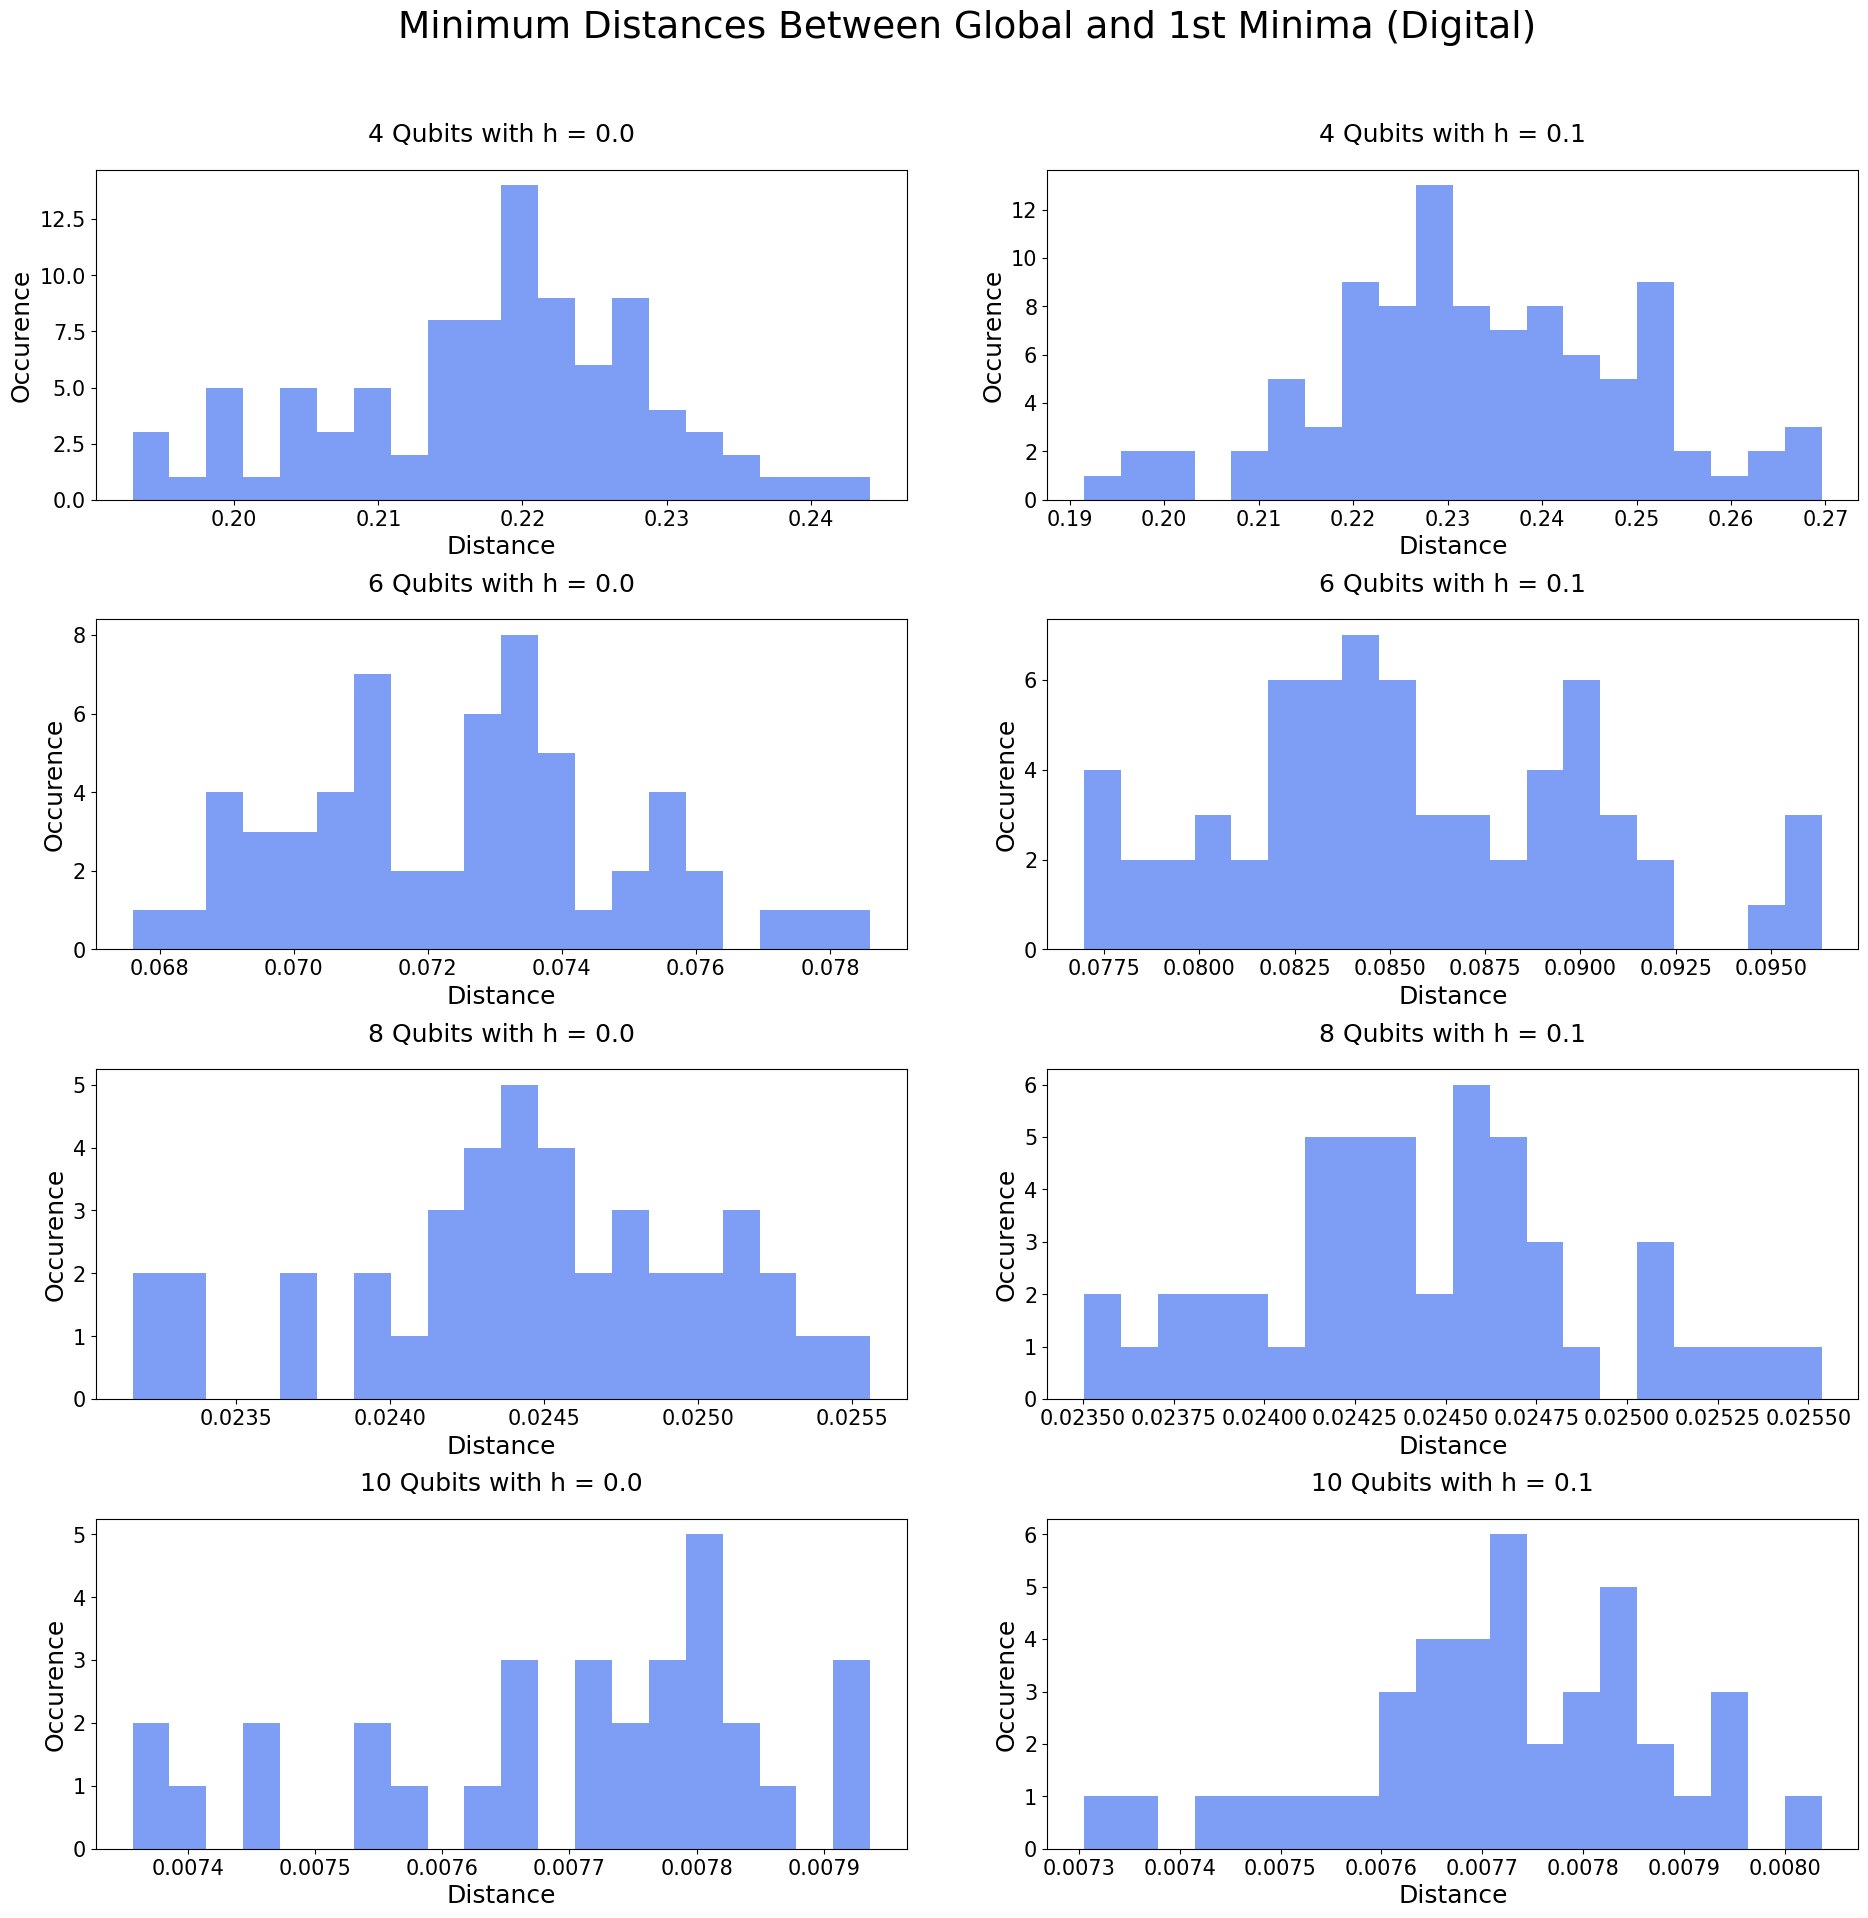

In [17]:
from scipy.spatial.distance import cdist

MOSAIC = """
        AE
        BF
        CG
        DH
        """

ax_mapping = {
    '4_0.0': 'A',
    '4_0.1': 'E',
    '6_0.0': 'B',
    '6_0.1': 'F',
    '8_0.0': 'C',
    '8_0.1': 'G',
    '10_0.0': 'D',
    '10_0.1': 'H',
}


std_min_distances = []
average_min_distances = []
# frequencies = []
qubit_number = []
transverse_fields = []


fig, ax_dict = plt.subplot_mosaic(MOSAIC, figsize=(20,20))

fig.tight_layout(pad=7.0)


for problem in vqe_problems:

    n_qubits = problem['qubits']
    h_parameter = problem['transverse_field_coefficient']

    qubit_number.append(n_qubits)
    transverse_fields.append(h_parameter)

    simulation_results = problem['simulation_results']
    spectrum_dict = simulation_results['spectrum_dictionary']

    # Ground State Data

    ground_state_data = spectrum_dict['0_excited_state']

    ground_state_final_parameters = ground_state_data['final_parameters']

    first_excited_state_data = spectrum_dict['1_excited_state']

    first_excited_state_final_parameters = first_excited_state_data['final_parameters']

    distances = cdist(ground_state_final_parameters, first_excited_state_final_parameters)/(2**n_qubits)

    min_distances = np.min(distances, axis=1)

    average_distances = np.mean(distances, axis=1)
    std_distances = np.std(distances, axis=1)

    average_min_distance = np.mean(min_distances)
    std_min_distance = np.std(min_distances)

    average_min_distances.append(average_min_distance)
    std_min_distances.append(std_min_distance)

    key = f'{n_qubits}_{h_parameter}'
    ax_key = ax_mapping[key]
    # print(key)
    ax = ax_dict[ax_key]


    ax.hist(min_distances, bins = 20, align="mid", color=plt.get_cmap("coolwarm", 7)(1), alpha=0.9)
    ax.set_title(f"{n_qubits} Qubits with h = {h_parameter} (Digital)", fontsize=title_fontsize, pad=20)
    ax.set_title(f"{n_qubits} Qubits with h = {h_parameter}", fontsize=title_fontsize, pad=20)
    ax.set_xlabel("Distance", fontsize=label_fontsize)
    ax.set_ylabel("Occurence", fontsize=label_fontsize)
    ax.tick_params(labelsize=tick_fontsize)



fig.suptitle('Minimum Distances Between Global and 1st Minima (Digital)', fontsize=title_fontsize*1.5)


plt.subplots_adjust(top=0.9)


filename = results_path + 'minimum_distances_between_global_first_minima_histogram.pdf'


plt.savefig(filename, bbox_inches="tight")



# print(average_distances)
# print(average_min_distances)


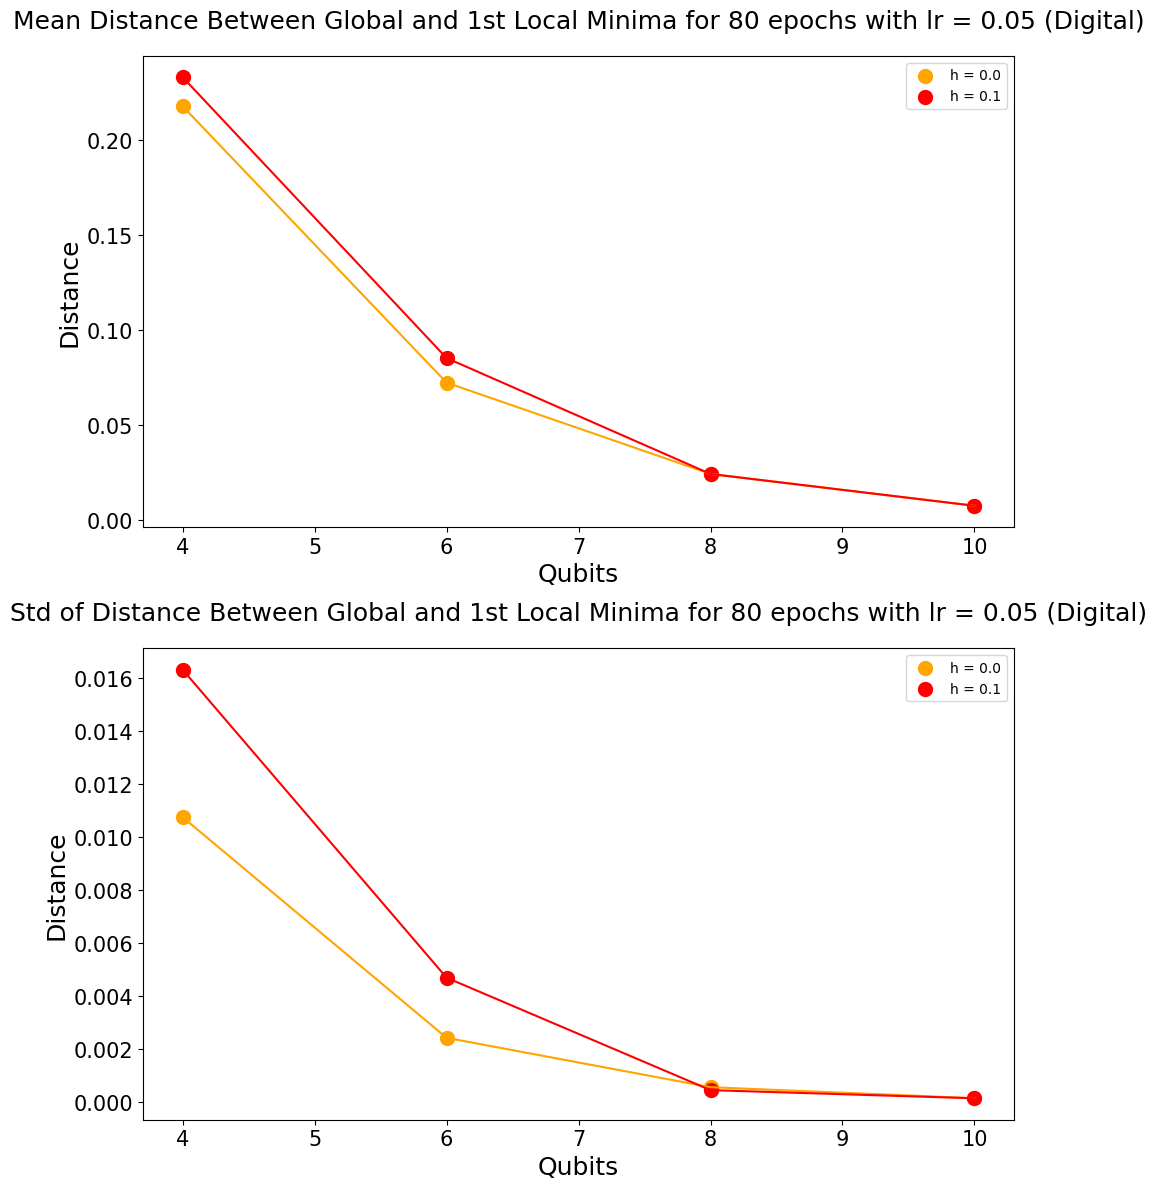

In [18]:
MOSAIC = """
        A
        B
        """


# frequencies = np.asarray(frequencies)/100
transverse_fields = np.asarray(transverse_fields)
qubit_number = np.asarray(qubit_number)
std_min_distances = np.asarray(std_min_distances)
average_min_distances = np.asarray(average_min_distances)

###############################
# Mean and Std plots


fig, ax_dict = plt.subplot_mosaic(MOSAIC, figsize=(10,12))


fig.tight_layout(pad=7.0)


# frequencies = np.asarray(frequencies)/100
transverse_fields = np.asarray(transverse_fields)
qubit_number = np.asarray(qubit_number)

field_filter = np.where(transverse_fields==0.0, True, False)


# colors = np.where(transverse_fields==0.1, 'red', 'blue')

# 0.0 Field

ax_mean = ax_dict['A']

ax_mean.scatter(qubit_number[field_filter], average_min_distances[field_filter], s=100, c='orange', label = 'h = 0.0')
ax_mean.plot(qubit_number[field_filter], average_min_distances[field_filter], c='orange')

# 0.1 Field

ax_mean.scatter(qubit_number[~field_filter], average_min_distances[~field_filter], s=100, c='red', label = 'h = 0.1')
ax_mean.plot(qubit_number[~field_filter], average_min_distances[~field_filter], c='red')

ax_mean.set_ylabel('Distance', fontsize=label_fontsize)
ax_mean.set_xlabel('Qubits', fontsize=label_fontsize)
ax_mean.set_title(f'Mean Distance Between Global and 1st Local Minima for 80 epochs with lr = 0.05 (Digital)', fontsize=label_fontsize, pad=20)
# ax_mean.yaxis.set_major_formatter(PercentFormatter(1))
ax_mean.tick_params(labelsize=tick_fontsize)

ax_std = ax_dict['B']


ax_std.scatter(qubit_number[field_filter], std_min_distances[field_filter], s=100, c='orange', label = 'h = 0.0')
ax_std.plot(qubit_number[field_filter], std_min_distances[field_filter], c='orange')


# 0.1 Field

ax_std.scatter(qubit_number[~field_filter], std_min_distances[~field_filter], s=100, c='red', label = 'h = 0.1')
ax_std.plot(qubit_number[~field_filter], std_min_distances[~field_filter], c='red')

ax_std.set_ylabel('Distance', fontsize=label_fontsize)
ax_std.set_xlabel('Qubits', fontsize=label_fontsize)
ax_std.set_title(f'Std of Distance Between Global and 1st Local Minima for 80 epochs with lr = 0.05 (Digital)', fontsize=label_fontsize, pad=20)
# ax_mean.yaxis.set_major_formatter(PercentFormatter(1))
ax_std.tick_params(labelsize=tick_fontsize)


ax_std.legend()
ax_mean.legend()

plt.tight_layout()


filename = results_path + 'minimum_distances_between_global_first_minima_statistics.pdf'


plt.savefig(filename, bbox_inches="tight")


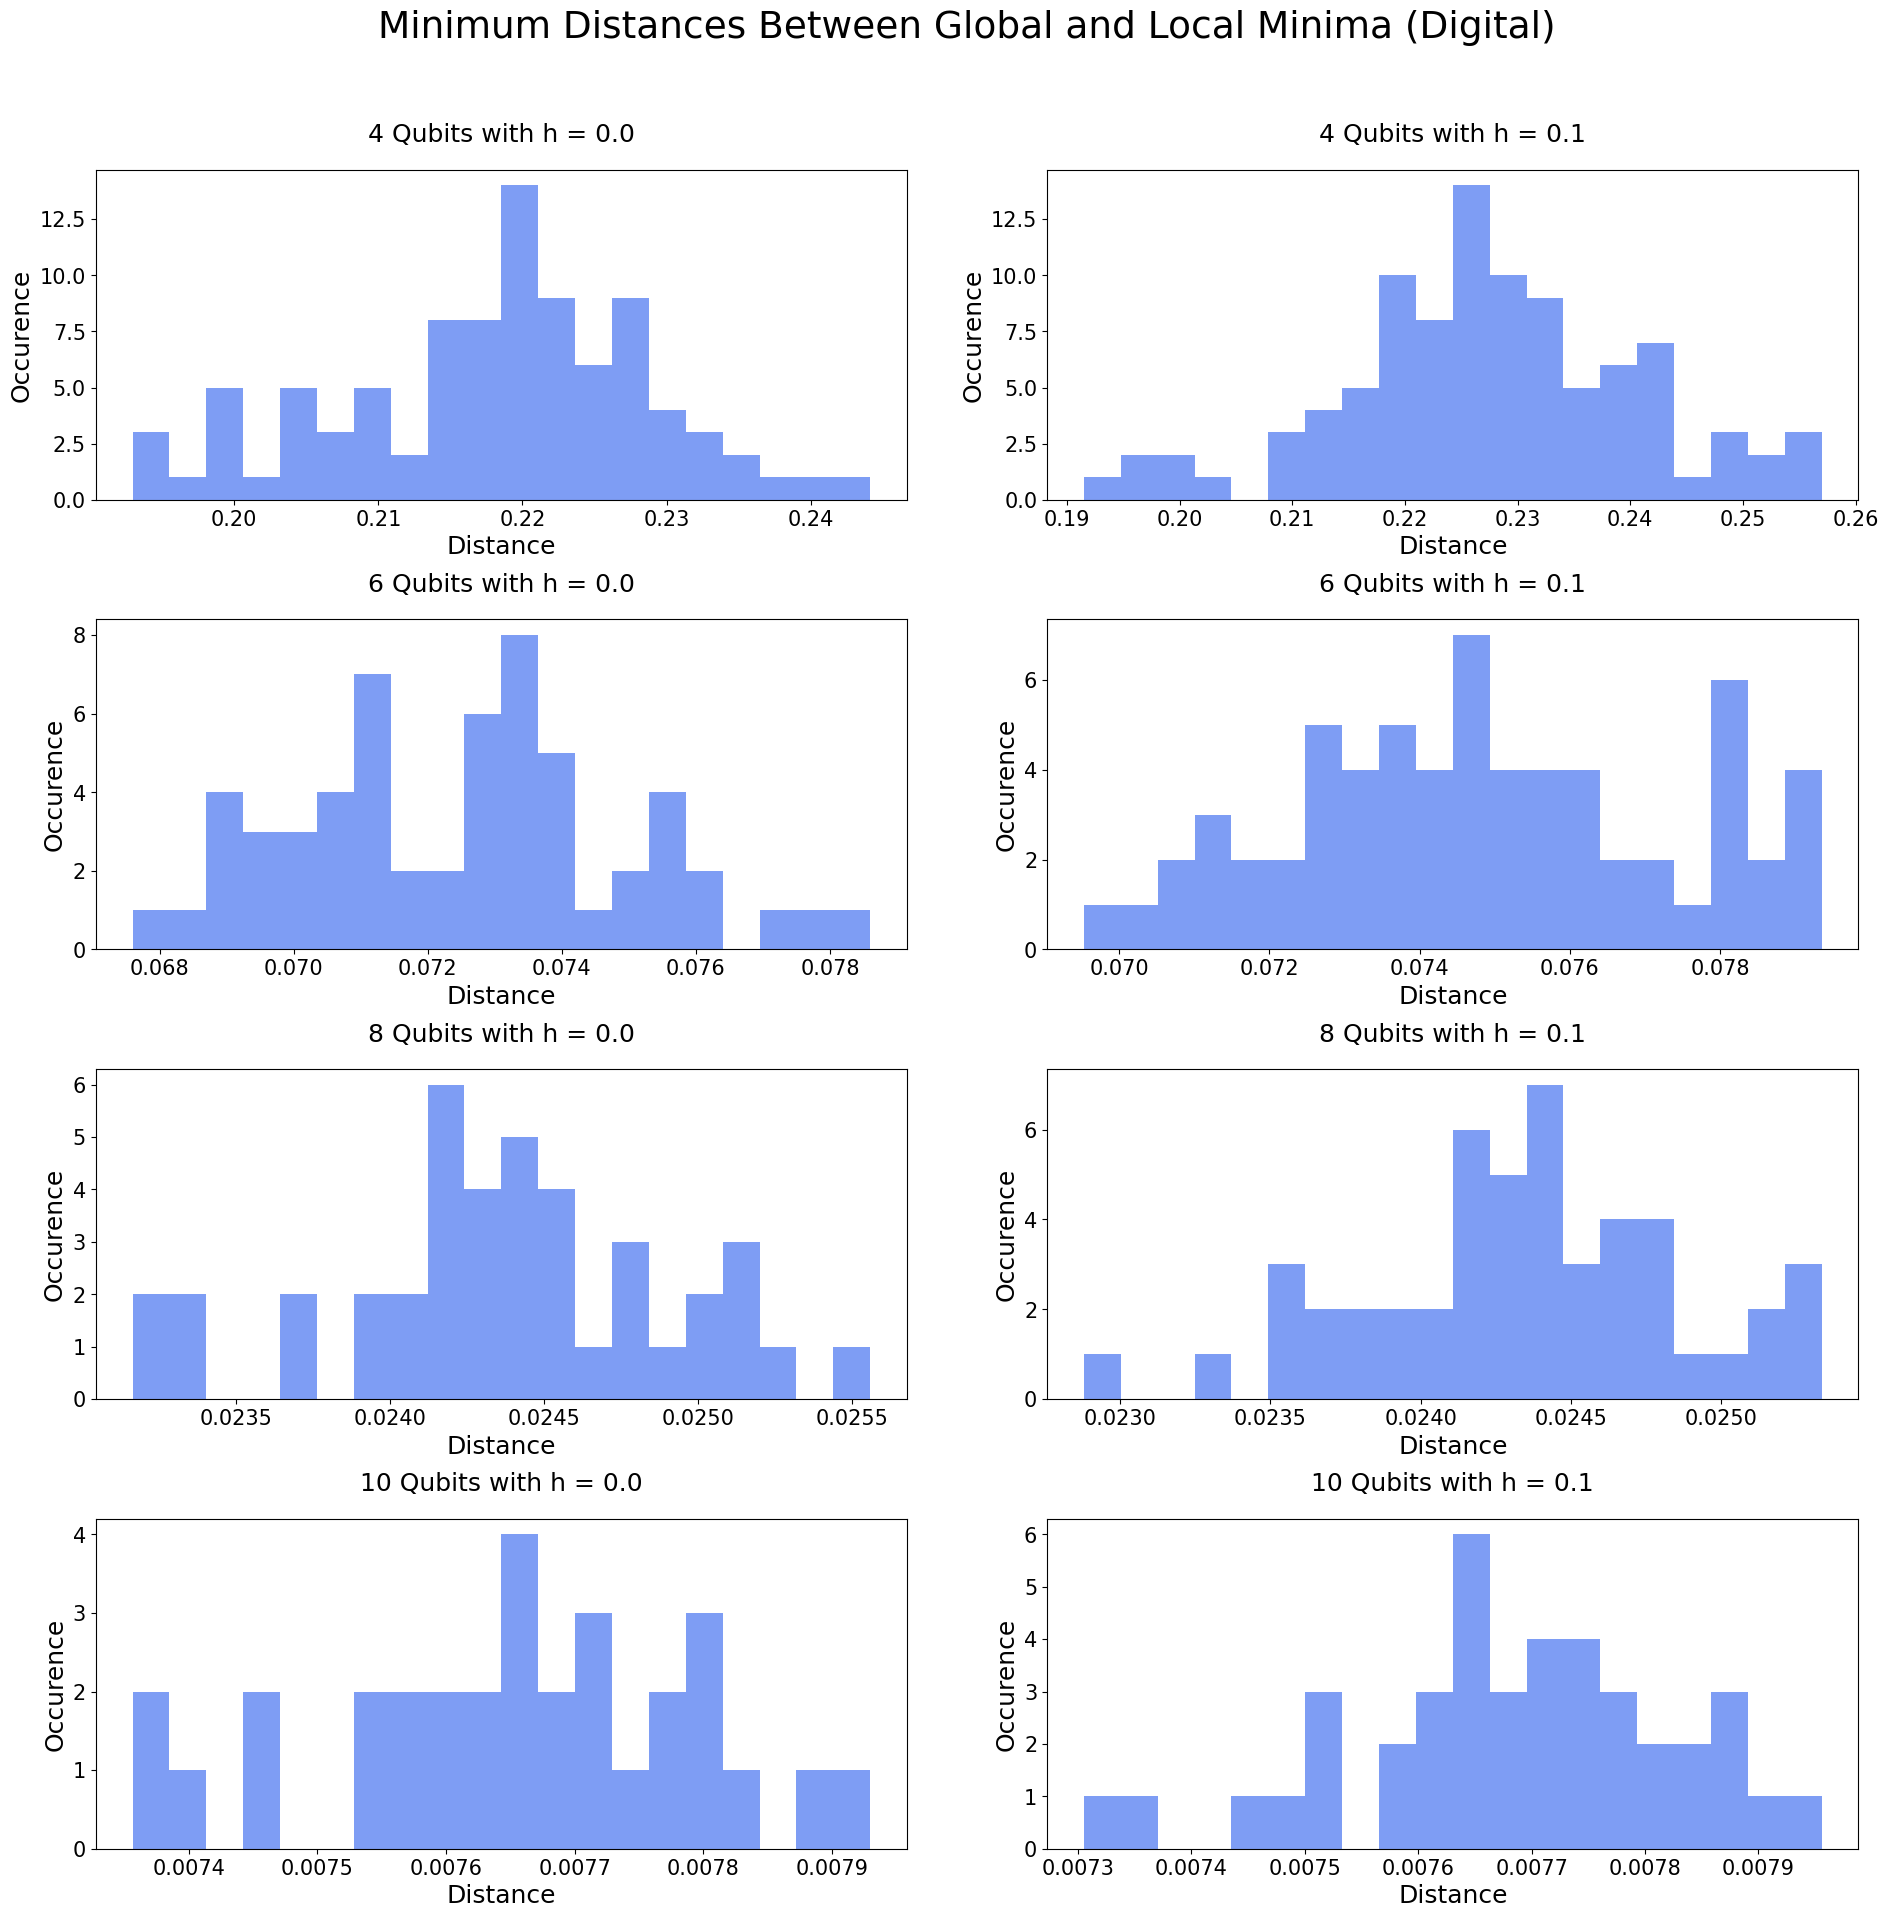

In [19]:
from scipy.spatial.distance import cdist

MOSAIC = """
        AE
        BF
        CG
        DH
        """

ax_mapping = {
    '4_0.0': 'A',
    '4_0.1': 'E',
    '6_0.0': 'B',
    '6_0.1': 'F',
    '8_0.0': 'C',
    '8_0.1': 'G',
    '10_0.0': 'D',
    '10_0.1': 'H',
}


std_min_distances = []
average_min_distances = []
# frequencies = []
qubit_number = []
transverse_fields = []


fig, ax_dict = plt.subplot_mosaic(MOSAIC, figsize=(20,20))

fig.tight_layout(pad=7.0)

for problem in vqe_problems:

    n_qubits = problem['qubits']
    h_parameter = problem['transverse_field_coefficient']

    qubit_number.append(n_qubits)
    transverse_fields.append(h_parameter)

    simulation_results = problem['simulation_results']
    final_parameters_split = simulation_results['final_parameters_split']

    # Ground State Data

    # ground_state_para = spectrum_dict['0_excited_state']

    global_minima_final_parameters = final_parameters_split[0]

    # first_excited_state_data = spectrum_dict['1_excited_state']

    local_minima_final_parameters = np.concatenate(final_parameters_split[1:])

    # print(local_minima_final_parameters.shape)
    # print(global_minima_final_parameters.shape)

    distances = cdist(global_minima_final_parameters, local_minima_final_parameters)/(2**n_qubits)

    min_distances = np.min(distances, axis=1)

    average_distances = np.mean(distances, axis=1)
    std_distances = np.std(distances, axis=1)

    average_min_distance = np.mean(min_distances)
    std_min_distance = np.std(min_distances)

    average_min_distances.append(average_min_distance)
    std_min_distances.append(std_min_distance)

    key = f'{n_qubits}_{h_parameter}'
    ax_key = ax_mapping[key]
    # print(key)
    ax = ax_dict[ax_key]


    ax.hist(min_distances, bins = 20, align="mid", color=plt.get_cmap("coolwarm", 7)(1), alpha=0.9)
    ax.set_title(f"{n_qubits} Qubits with h = {h_parameter} (Digital)", fontsize=title_fontsize, pad=20)
    ax.set_title(f"{n_qubits} Qubits with h = {h_parameter}", fontsize=title_fontsize, pad=20)
    ax.set_xlabel("Distance", fontsize=label_fontsize)
    ax.set_ylabel("Occurence", fontsize=label_fontsize)
    ax.tick_params(labelsize=tick_fontsize)



fig.suptitle('Minimum Distances Between Global and Local Minima (Digital)', fontsize=title_fontsize*1.5)


plt.subplots_adjust(top=0.9)


filename = results_path + 'minimum_distances_between_global_local_minima_histogram.pdf'


plt.savefig(filename, bbox_inches="tight")




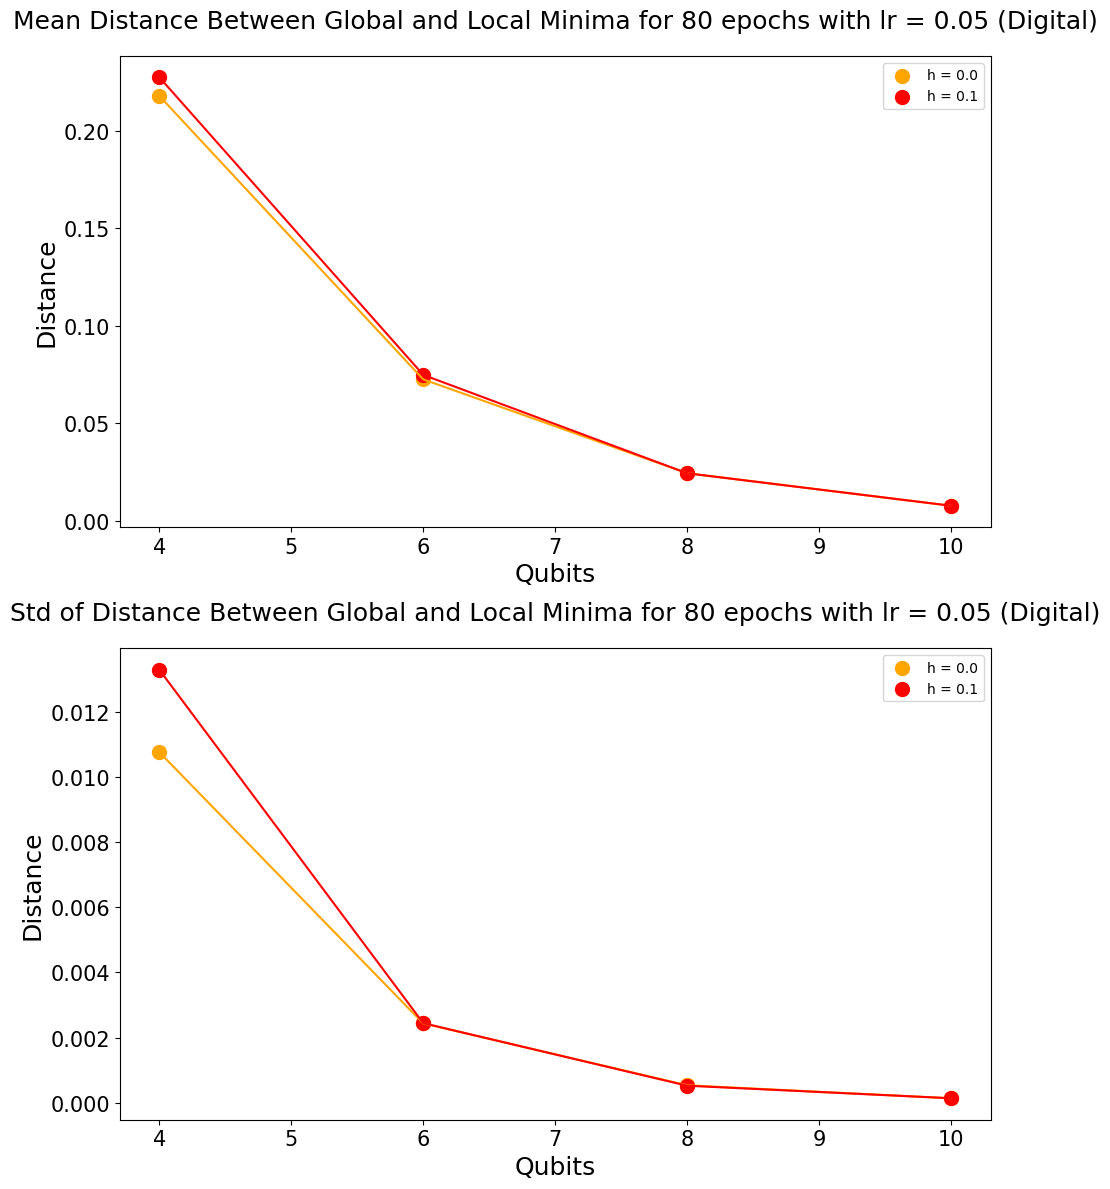

In [20]:
MOSAIC = """
        A
        B
        """


# frequencies = np.asarray(frequencies)/100
transverse_fields = np.asarray(transverse_fields)
qubit_number = np.asarray(qubit_number)
std_min_distances = np.asarray(std_min_distances)
average_min_distances = np.asarray(average_min_distances)

###############################
# Mean and Std plots


fig, ax_dict = plt.subplot_mosaic(MOSAIC, figsize=(10,12))


fig.tight_layout(pad=7.0)


# frequencies = np.asarray(frequencies)/100
transverse_fields = np.asarray(transverse_fields)
qubit_number = np.asarray(qubit_number)

field_filter = np.where(transverse_fields==0.0, True, False)


# colors = np.where(transverse_fields==0.1, 'red', 'blue')

# 0.0 Field

ax_mean = ax_dict['A']

ax_mean.scatter(qubit_number[field_filter], average_min_distances[field_filter], s=100, c='orange', label = 'h = 0.0')
ax_mean.plot(qubit_number[field_filter], average_min_distances[field_filter], c='orange')

# 0.1 Field

ax_mean.scatter(qubit_number[~field_filter], average_min_distances[~field_filter], s=100, c='red', label = 'h = 0.1')
ax_mean.plot(qubit_number[~field_filter], average_min_distances[~field_filter], c='red')

ax_mean.set_ylabel('Distance', fontsize=label_fontsize)
ax_mean.set_xlabel('Qubits', fontsize=label_fontsize)
ax_mean.set_title(f'Mean Distance Between Global and Local Minima for 80 epochs with lr = 0.05 (Digital)', fontsize=label_fontsize, pad=20)
# ax_mean.yaxis.set_major_formatter(PercentFormatter(1))
ax_mean.tick_params(labelsize=tick_fontsize)

ax_std = ax_dict['B']


ax_std.scatter(qubit_number[field_filter], std_min_distances[field_filter], s=100, c='orange', label = 'h = 0.0')
ax_std.plot(qubit_number[field_filter], std_min_distances[field_filter], c='orange')


# 0.1 Field

ax_std.scatter(qubit_number[~field_filter], std_min_distances[~field_filter], s=100, c='red', label = 'h = 0.1')
ax_std.plot(qubit_number[~field_filter], std_min_distances[~field_filter], c='red')

ax_std.set_ylabel('Distance', fontsize=label_fontsize)
ax_std.set_xlabel('Qubits', fontsize=label_fontsize)
ax_std.set_title(f'Std of Distance Between Global and Local Minima for 80 epochs with lr = 0.05 (Digital)', fontsize=label_fontsize, pad=20)
# ax_mean.yaxis.set_major_formatter(PercentFormatter(1))
ax_std.tick_params(labelsize=tick_fontsize)


ax_std.legend()
ax_mean.legend()

plt.tight_layout()


filename = results_path + 'minimum_distances_between_global_local_minima_statistics.pdf'


plt.savefig(filename, bbox_inches="tight")
